In [1]:
from pigments import generate_pigments, generate_mixtures
from visualization import plot_pigment_colors, plot_mixture_colors, plot_multispectral_results
import numpy as np
from multispectral_measurement import multispectral_experiment
from unmixing import bayesian_unmixing, naive_unmixing, greedy_unmixing
from diagnostics import posterior_predictive_check, posterior_diagnostics, compare_all_predictions, weight_mse, display_mse_comparison
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

# Pigment Generation

Here, I will use the function **generate_pigments** to simulate 5 pigments. To do so, absoption and scattering profiles are generated for each pigment over a selected range of wavelengths (in this case from 300 nm to 800 nm). The absorption and scattering for any given pigment are kept somewhat negatively correlated to maintain physical realism. 

**Kubelka-Munk Theory** is then used to generate the reflectance curves from the absorbance and scattering profiles. This is, following:

$$\frac{K}{S} = \frac{(1 - R)^2}{2R}$$

Where $R$ is the reflectance, $K$ is the absorption and $S$ is the scattering.

The pigments are then visualized by transforming the reflectance curves to RGB using **colour-science**

I use the random seed to explore different collections of randomly generated pigments and kept one where the pigments are sufficiently different from each other for this demonstration. Unmixing performace could also be explored for collections of pigments that are more similar to each other.

In [2]:
wavelengths, reflectance, absorption, scattering, pigment_colors = generate_pigments(
    num_pigments=5,
    wavelength_start=300,
    wavelength_end=800,
    max_peaks_per_pigment=15,
    peak_strength_range=(2,10),
    peak_width_range=(10, 100),
    correlation_strength=0.4,
    K_min=0.1,
    pre_peak_smoothing_sigma=4,
    post_peak_smoothing_sigma=2,
    K_baseline=3.0,
    S_baseline=3.0,
    K_variation=2.5,
    S_variation=2.5,
    seed=38 #38 #1400
)

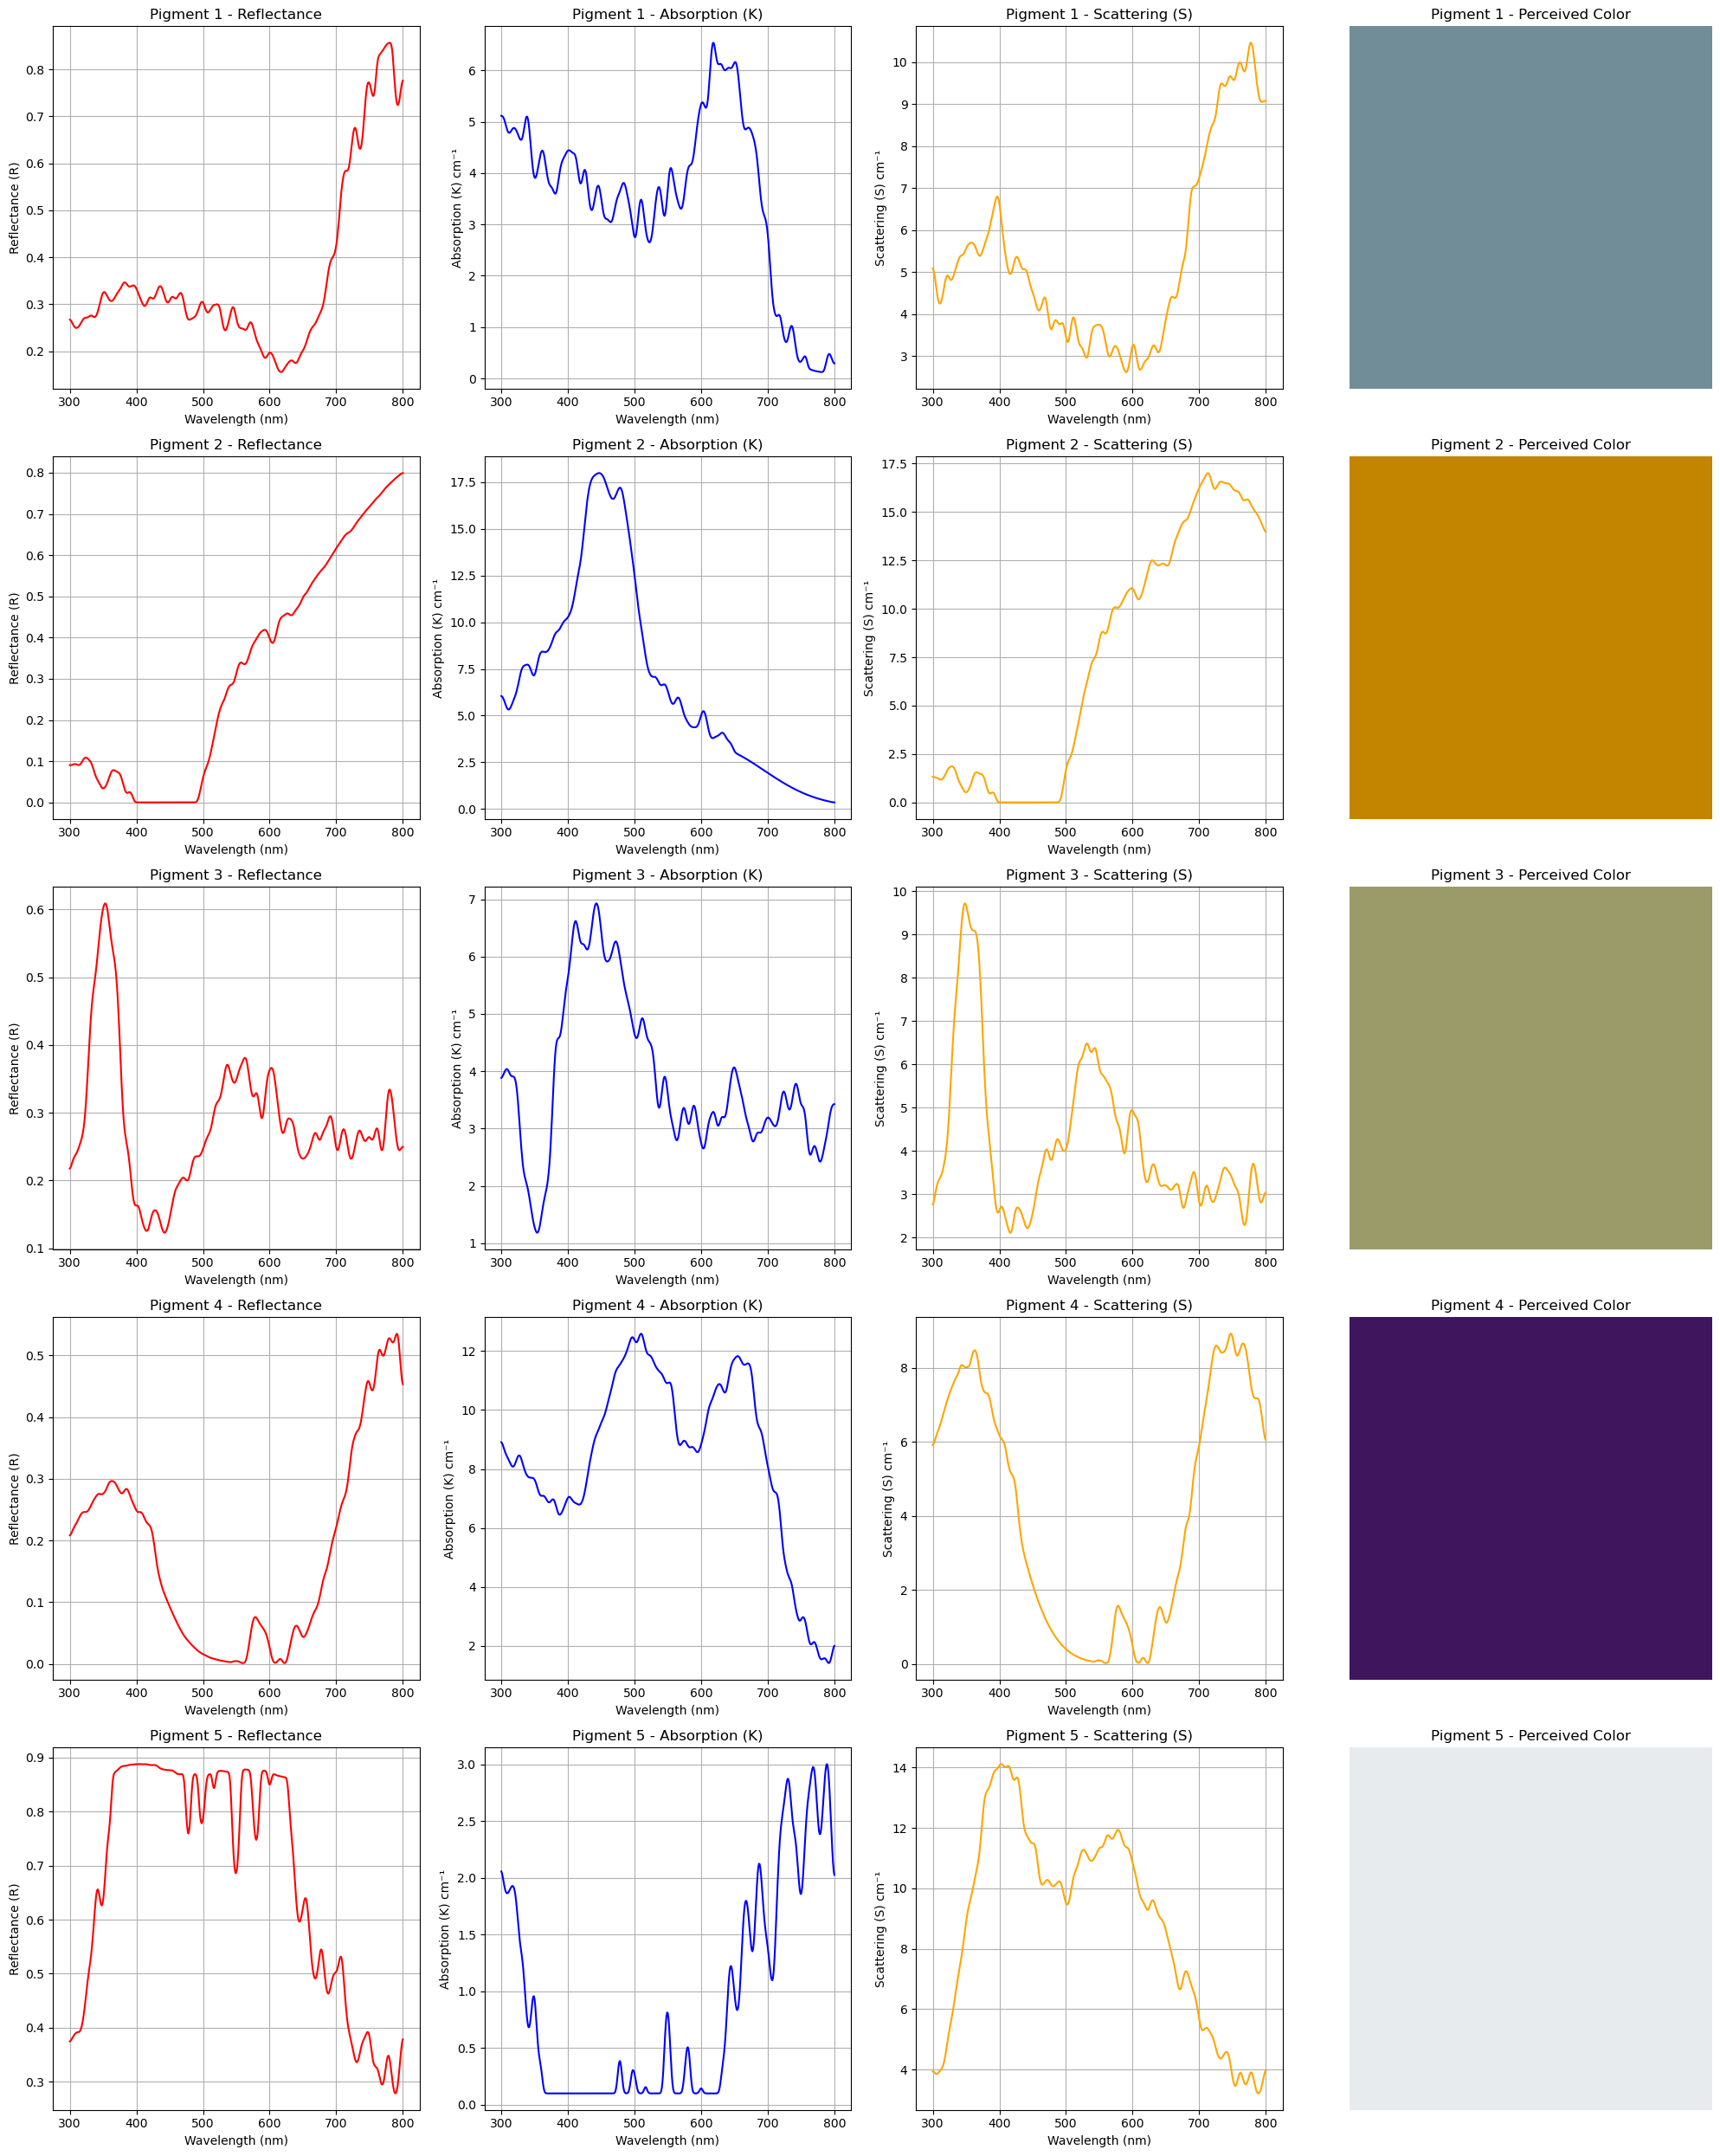

In [3]:
plot_pigment_colors(wavelengths, reflectance, absorption, scattering, pigment_colors)

# Pigment Mixtures

The function **generate_mixtures** is used to create pigment mixtures, where each mixture is given a specific weight. In the idealized case, **Kubelka-Munk theory** is used, where the absorbance and scattering add up linearly, each one sclaed by their weight in the mixture.

I have also included the possibility to deviate from ideal Kubelka-Munk mixing by introducing interaction terms. Physically, these interaction terms can be interpreted as optical interference or chemical interaction between the pigments. The strength of the corrections are controlled by parameters $\alpha$ (for absorption) and $\beta$ (for scattering), in a way that when $\alpha = \beta = 0$ the model reverts to ideal Kubelka-Munk mixing.

The mixing is governed by these equations:

$$
K_{\text{mix}}(\lambda) = \sum_{i=1}^{N} \left( K_i(\lambda) \cdot w_i \right) + \alpha \cdot \sum_{i=1}^{N} \sum_{j=i+1}^{N} \left(\frac{\langle K_i \rangle + \langle K_j \rangle}{2}\right) \cdot w_i \cdot w_j
$$

$$
S_{\text{mix}}(\lambda) = \sum_{i=1}^{N} \left( S_i(\lambda) \cdot w_i \right) + \beta \cdot \sum_{i=1}^{N} \sum_{j=i+1}^{N} \left(\frac{\langle S_i \rangle + \langle S_j \rangle}{2}\right) \cdot w_i \cdot w_j
$$

## Mixing Cases
To test the unmixing models, I will mix the above pigments in a number of ways.

### Case 1
Use Pigments 1, 2, 3 with equal weights 

Ideal KM mixing

### Case 2
Use Pigments 1, 2, 3 with respective weights 0.5, 0.3, 0.2

Ideal KM mixing

## Case 3
Use Pigments 1, 2, 3, 4, 5 with weights 0.2, 0.1, 0.1, 0.3, 0.2

Ideal KM mixing

### Case 4:
Use Pigments 1, 2, 3, 4 , 5 with weights 1/3, 1/3 1/3, 0, 0

Ideal KM mixing

This is to test unmixing performance when given a library of pigments where not all of them are used.

### Case 5:
Use Pigments 1, 2, 3 with weights 0.3, 0.4, 0.2

Weak interaction terms.

### Case 6: 
Use Pigments 1, 2, 3 with weights 0.3, 0.4, 0.2

Strong interaction terms

In [4]:
mixture_indexes = np.array(
    [
        [0,1,2,3,4],
        [0,1,2,3,4],
        [0,1,2,3,4],
        [0,1,2,3,4],
        [0,1,2,3,4],
        [0,1,2,3,4]
    ]
)

weights = np.array(
    [
        [1/3, 1/3, 1/3, 0, 0],
        [0.5, 0.3, 0.2, 0, 0],
        [0.2, 0.1, 0.1, 0.3, 0.2],
        [1/3, 1/3, 1/3, 0, 0],
        [0.3, 0.4, 0.2, 0, 0],
        [0.3, 0.4, 0.2, 0, 0]
    ]
)

to_use = np.array(
    [
        [1, 1, 1, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 0, 0]
    ]
)

alpha =  np.array(
    [0, 0, 0, 0, 0.5, 3]
)

beta = np.array(
    [0,0,0,0,0,0]
)

In [5]:
mixture_reflectance, mixture_absorption, mixture_scattering, mixture_colors = generate_mixtures(
        wavelengths, 
        absorption, 
        scattering,
        mixture_indexes, 
        weights,
        alpha,
        beta,
)

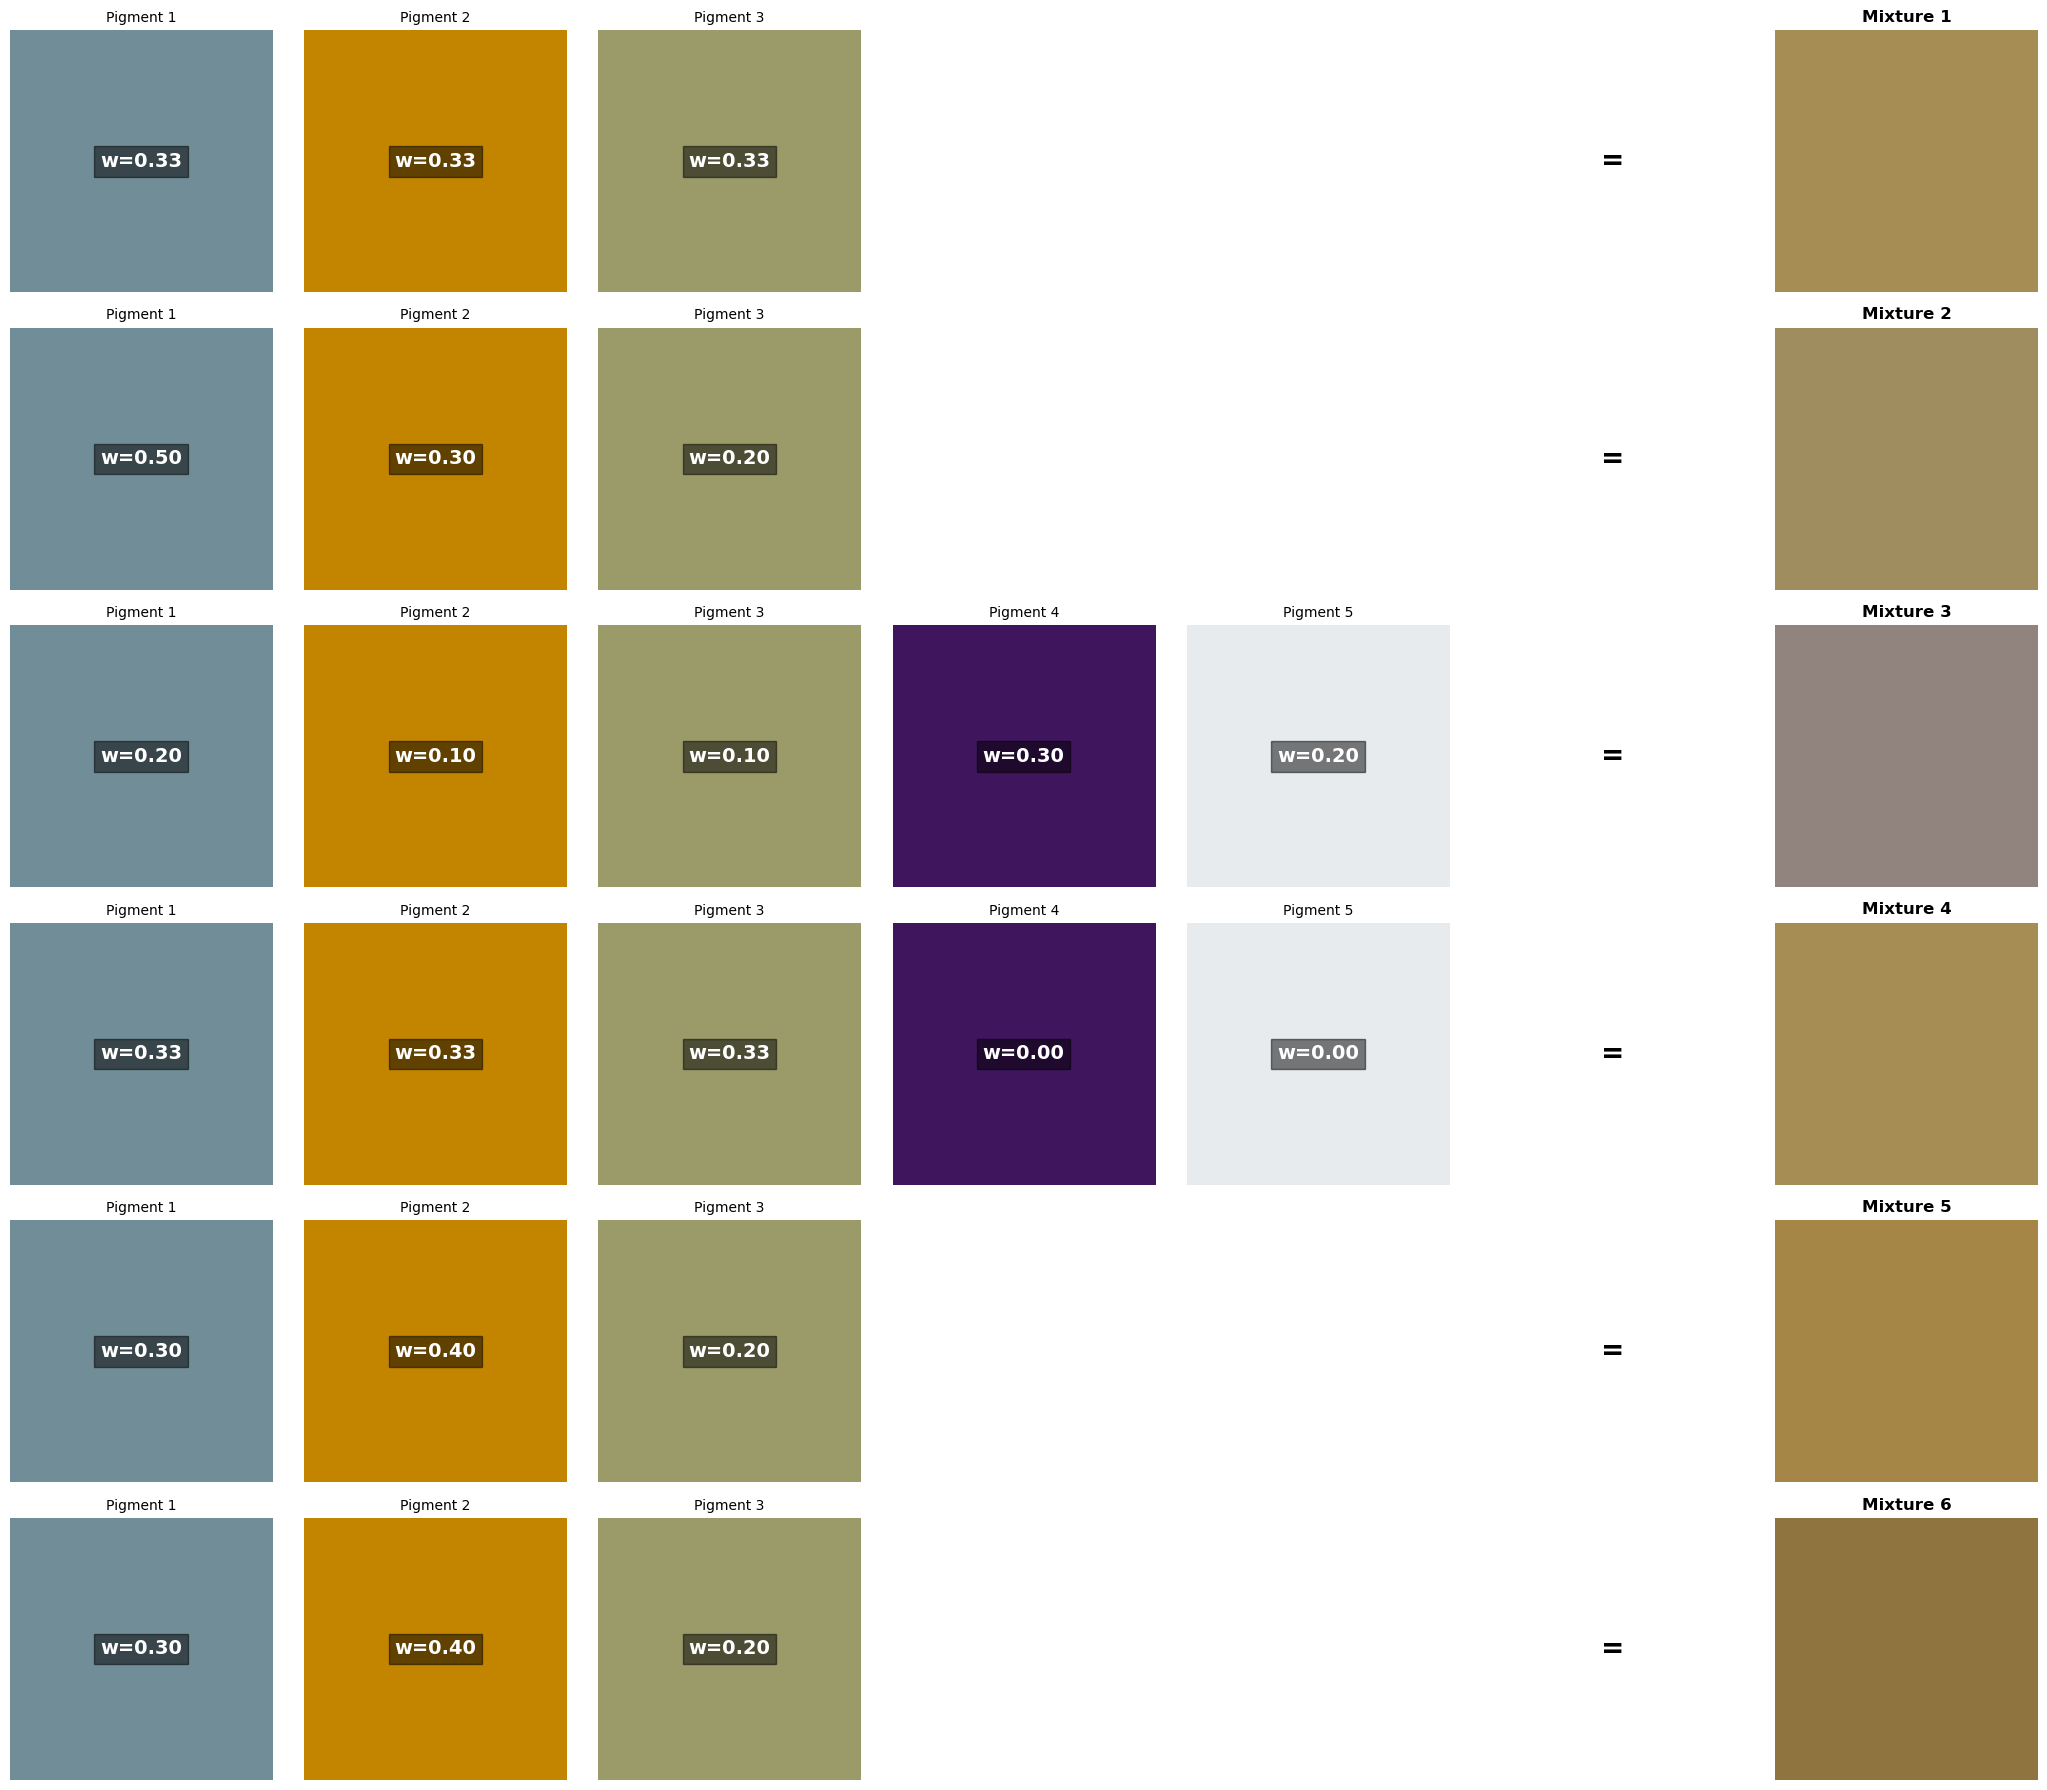

In [6]:
plot_mixture_colors(mixture_indexes, mixture_colors, pigment_colors, weights, to_use)

# Multispectral Experiment

Now I simulate a multispectral experiment on the reflectances of each mixtures. This I do by selecting 15 evenly spaced wavelengths (not wavelength bands, for simplicity) throughout the wavelength range 300 nm - 800 nm. I include a small noise parameter to simulate measurment error.

In [7]:
measured_wavelengths = np.linspace(wavelengths[0], wavelengths[-1], 15).astype(int)

In [8]:
multispectral_experiments = multispectral_experiment(wavelengths, measured_wavelengths, mixture_reflectance, measurement_noise = 0.01)

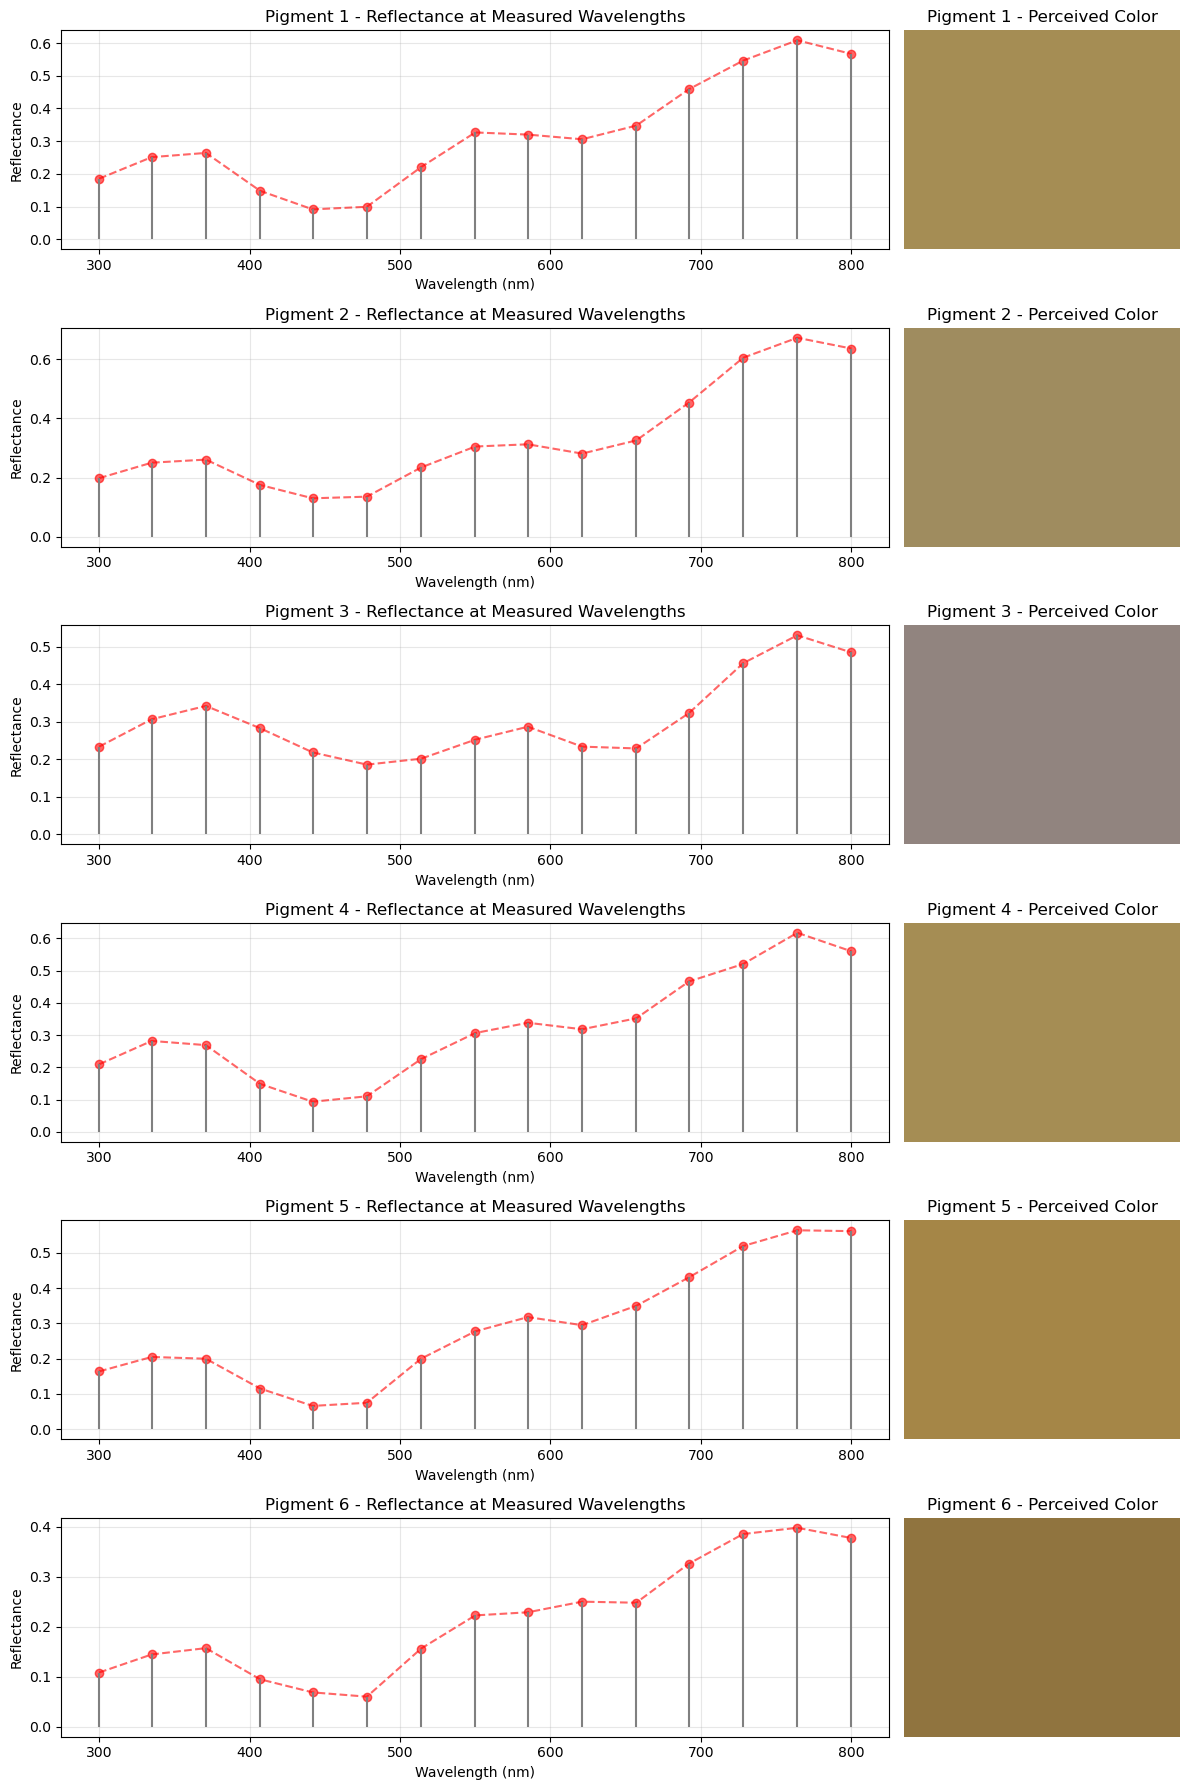

In [9]:
plot_multispectral_results(measured_wavelengths, multispectral_experiments, mixture_colors)

# Pigment Unmixing

Now I will test three methods por determining the weights of the constituents of each mixture. This assumes one has a library of well known pigments (the 5 pigments generated above), from which one knows the 6 mixtures where made from. The assumption includes that one knows the absorption and scattering profiles of these pigments.

At this stage we imagine we don't have access to the full absorbance/scattering profiles of the mixtures themselves, and we want to use our knowledge about their known constituents to determine the weights for each mixture. 

The methods are as follow:

## Naive Unmixing

Uses non-negative least squared optimization against the known pigments' absorbances and scatterings (with Kubelka-Munk theory to derive their reflectances) and the measured reflectance of the mixture.

## Greedy Unmixing

Uses a greedy approach to find the weights. It assumes a pure Kubelka-Munk mixing model and iteratively selects the best pigment that minimizes the mean squared error between the measured reflectance spectrum and the predicted one using the current weights and the MK mixing model.

## Bayesian Unmixing

Uses a Bayesian model to learn the probability distribution of weights for each pigment. It uses a normal distribution prior for each weight and a Student-T distribution as the likelyhood function, with an exponential distribution as prior for the degrees of freedom parameter $\nu$ parameter and a half normal prior for the noise scale parameter $\sigma$. Uses a Markov Chain Monte Carlo sampler to fit the posterior distribution, which can be used to understand the uncertainty in the predictions explicitly.



I will now run each of the models on each of the 6 mixture cases

### Case 1
Use Pigments 1, 2, 3 with equal weights 

Ideal KM mixing

In [10]:
# Naive unmixing
naive_w_case1 = naive_unmixing(
    multispectral_experiments[0],
    absorption[to_use[0].astype(bool), :],
    scattering[to_use[0].astype(bool), :],
    wavelengths,
    measured_wavelengths
)
naive_w_mse_case1 = weight_mse(naive_w_case1, weights[0, to_use[0].astype(bool)])
print('Naive unmixing weights:', naive_w_case1)
print('Naive unmixing weights MSE:', naive_w_mse_case1)

Naive unmixing weights: [ 0.23064036  0.43528052  0.33407912]
Naive unmixing weights MSE: 0.00697987664058


In [11]:
# Greedy unmixing
greedy_w_case1, greedy_R_case1 = greedy_unmixing(
    multispectral_experiments[0],
    absorption[to_use[0].astype(bool), :],
    scattering[to_use[0].astype(bool), :],
    wavelengths,
    measured_wavelengths
)
greedy_w_mse_case1 = weight_mse(greedy_w_case1, weights[0, to_use[0].astype(bool)])
print('Greedy unmixing weights:', greedy_w_case1)
print('Greedy unmixing weights MSE:', greedy_w_mse_case1)

Greedy unmixing weights: [ 0.33333333  0.33333333  0.33333333]
Greedy unmixing weights MSE: 0.0


In [12]:
# Bayesian unimixing
trace_case1, bayesian_model_case1 = bayesian_unmixing(
    multispectral_experiments[0], 
    absorption[to_use[0].astype(bool), :],
    scattering[to_use[0].astype(bool), :],
    wavelengths, 
    measured_wavelengths,
    draws=5000, 
    tune=1000, 
    chains=4, 
    target_accept=0.9
)
bayesian_w_case1 =  trace_case1.posterior["w"].mean(dim=["chain", "draw"]).values.tolist()
bayesian_w_mse_case1 = weight_mse(bayesian_w_case1, weights[0, to_use[0].astype(bool)])
print('Bayesian unmixing weights:', bayesian_w_case1)
print('Bayesian unmixing weights MSE:', bayesian_w_mse_case1)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_w, nu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 37 seconds.


Bayesian unmixing weights: [0.3183953000418432, 0.3438610934914055, 0.33774360646675117]
Bayesian unmixing weights MSE: 0.000117809693892


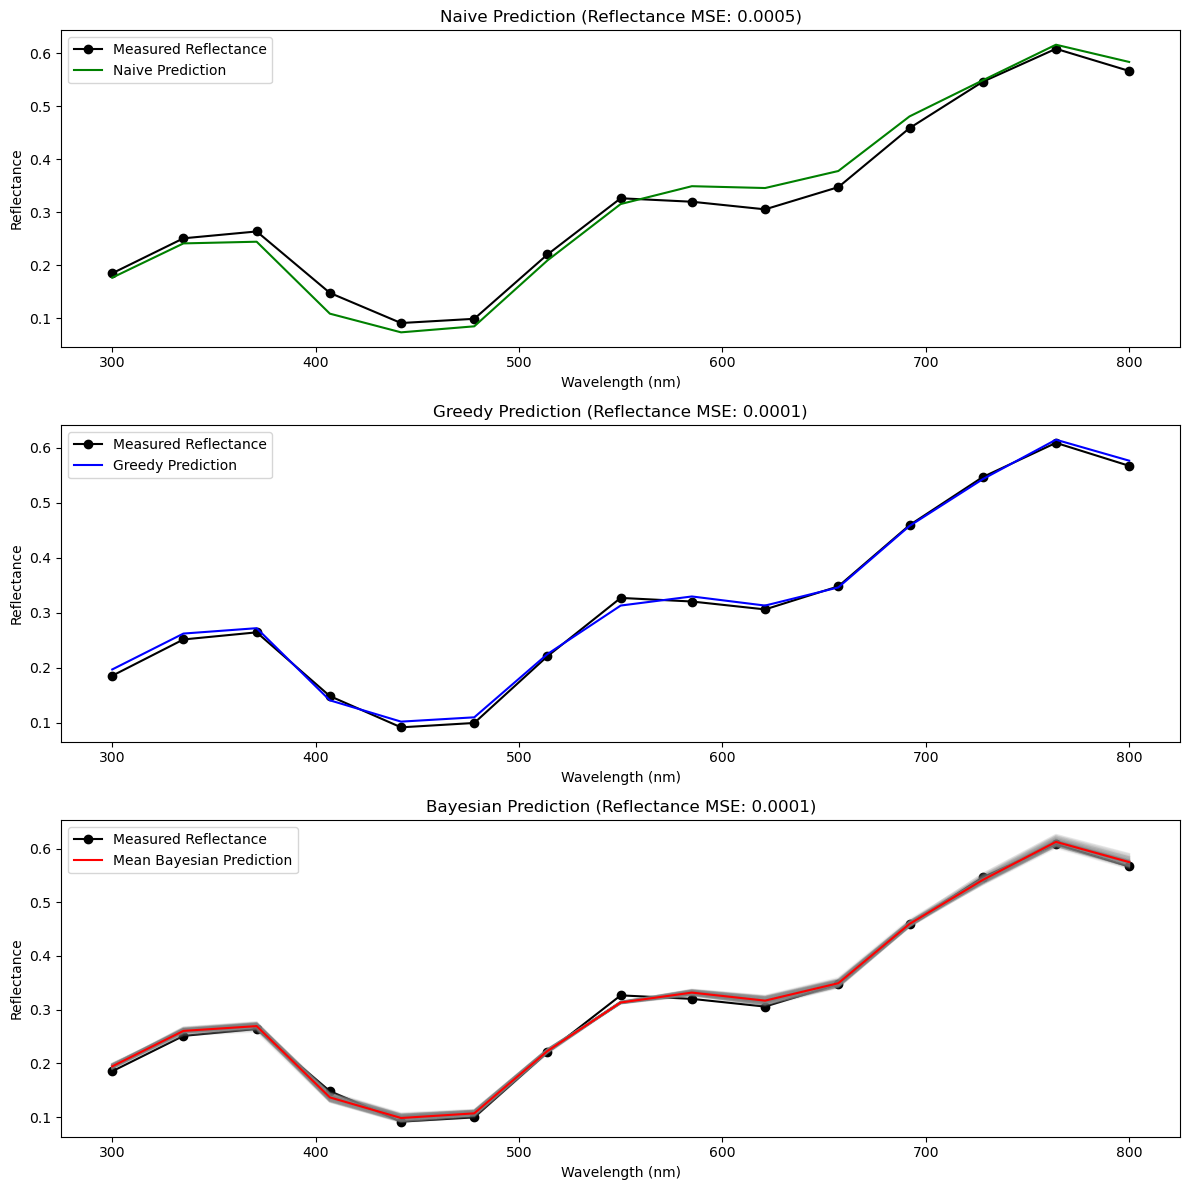

In [13]:
naive_R_mse_case1, greedy_R_mse_case1, bayesian_R_mse_case1 = compare_all_predictions(
    trace_case1, 
    greedy_w_case1, 
    naive_w_case1,
    multispectral_experiments[0], 
    absorption[to_use[0].astype(bool), :], 
    scattering[to_use[0].astype(bool), :],
    wavelengths, 
    measured_wavelengths
)

Bayesian Weights Distribution


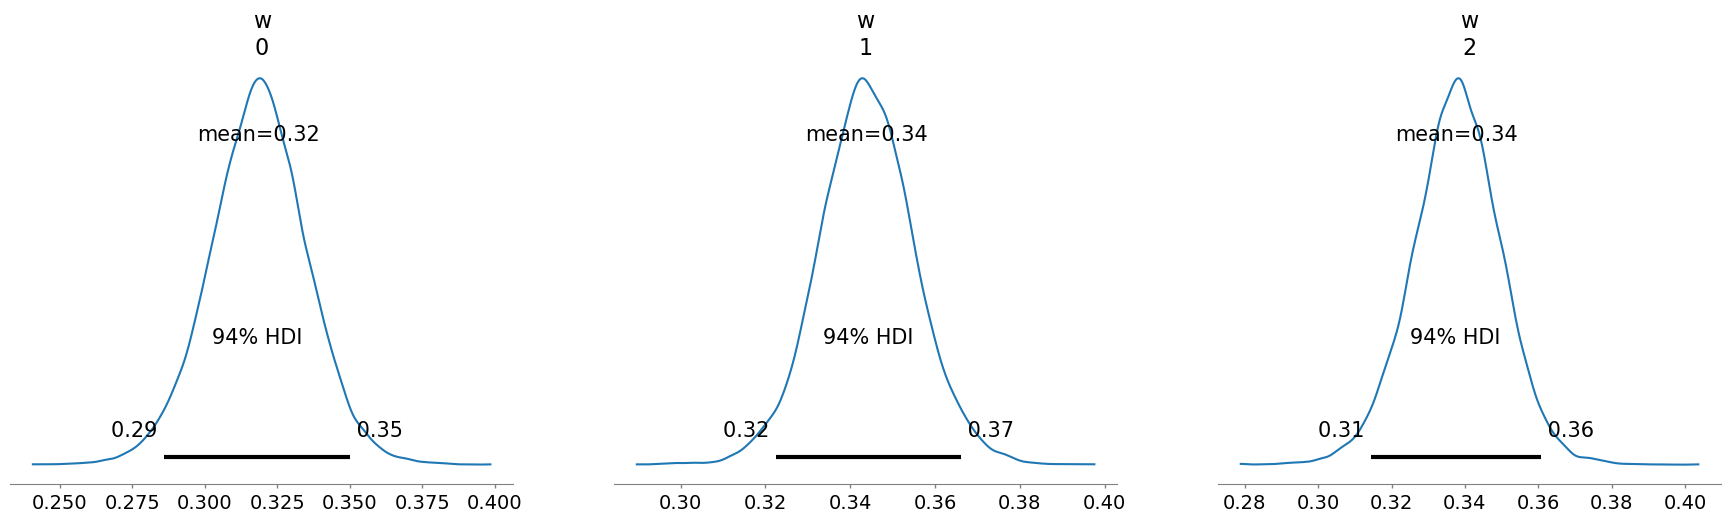

In [14]:
print('Bayesian Weights Distribution')
posterior_diagnostics(trace_case1)

### Case 2
Use Pigments 1, 2, 3 with respective weights 0.5, 0.3, 0.2

Ideal KM mixing

In [15]:
# Naive unmixing
naive_w_case2 = naive_unmixing(
    multispectral_experiments[1],
    absorption[to_use[1].astype(bool), :],
    scattering[to_use[1].astype(bool), :],
    wavelengths,
    measured_wavelengths
)
naive_w_mse_case2 = weight_mse(naive_w_case2, weights[1, to_use[1].astype(bool)])
print('Naive unmixing weights:', naive_w_case2)
print('Naive unmixing weights MSE:', naive_w_mse_case2)

Naive unmixing weights: [ 0.39910419  0.3756323   0.2252635 ]
Naive unmixing weights MSE: 0.00551281786876


In [16]:
# Greedy unmixing
greedy_w_case2, greedy_R_case2 = greedy_unmixing(
    multispectral_experiments[1],
    absorption[to_use[1].astype(bool), :],
    scattering[to_use[1].astype(bool), :],
    wavelengths,
    measured_wavelengths
)
greedy_w_mse_case2 = weight_mse(greedy_w_case2, weights[1, to_use[1].astype(bool)])
print('Greedy unmixing weights:', greedy_w_case2)
print('Greedy unmixing weights MSE:', greedy_w_mse_case2)

Greedy unmixing weights: [ 0.53333333  0.28333333  0.18333333]
Greedy unmixing weights MSE: 0.000555555555556


In [17]:
# Bayesian unimixing
trace_case2, bayesian_model_case2 = bayesian_unmixing(
    multispectral_experiments[1], 
    absorption[to_use[1].astype(bool), :],
    scattering[to_use[1].astype(bool), :],
    wavelengths, 
    measured_wavelengths,
    draws=5000, 
    tune=1000, 
    chains=4, 
    target_accept=0.9
)
bayesian_w_case2 =  trace_case2.posterior["w"].mean(dim=["chain", "draw"]).values.tolist()
bayesian_w_mse_case2 = weight_mse(bayesian_w_case2, weights[1, to_use[1].astype(bool)])
print('Bayesian unmixing weights:', bayesian_w_case2)
print('Bayesian unmixing weights MSE:', bayesian_w_mse_case2)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_w, nu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 60 seconds.


Bayesian unmixing weights: [0.5086062089737273, 0.2895344819687419, 0.20185930905752747]
Bayesian unmixing weights MSE: 6.23503102445e-05


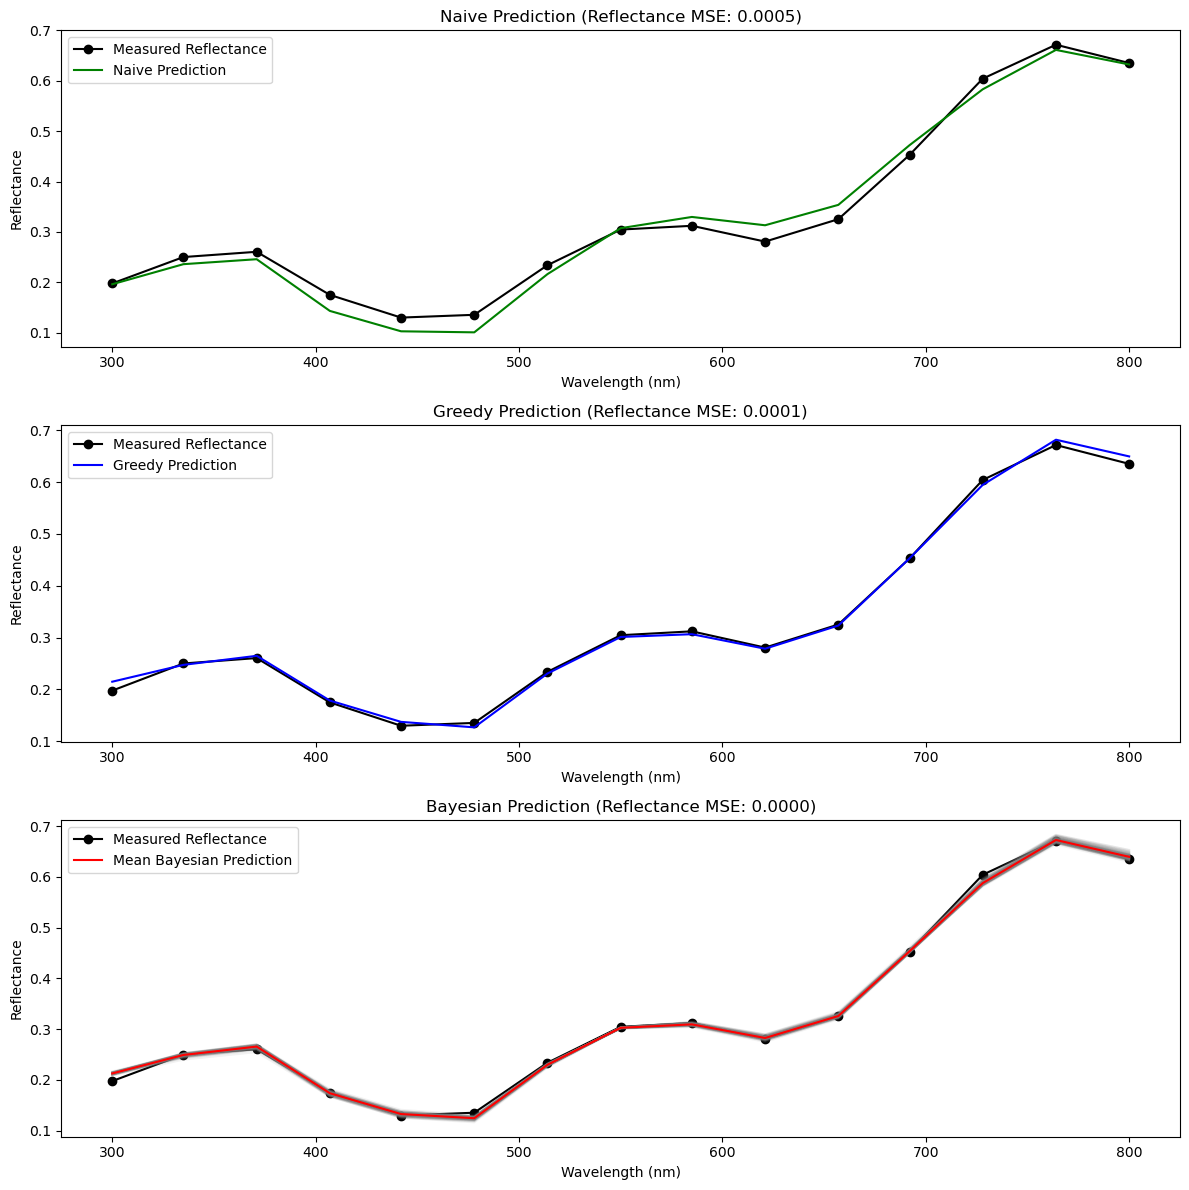

In [18]:
naive_R_mse_case2, greedy_R_mse_case2, bayesian_R_mse_case2 = compare_all_predictions(
    trace_case2, 
    greedy_w_case2, 
    naive_w_case2,
    multispectral_experiments[1], 
    absorption[to_use[1].astype(bool), :], 
    scattering[to_use[1].astype(bool), :],
    wavelengths, 
    measured_wavelengths
)

Bayesian Weights Distribution


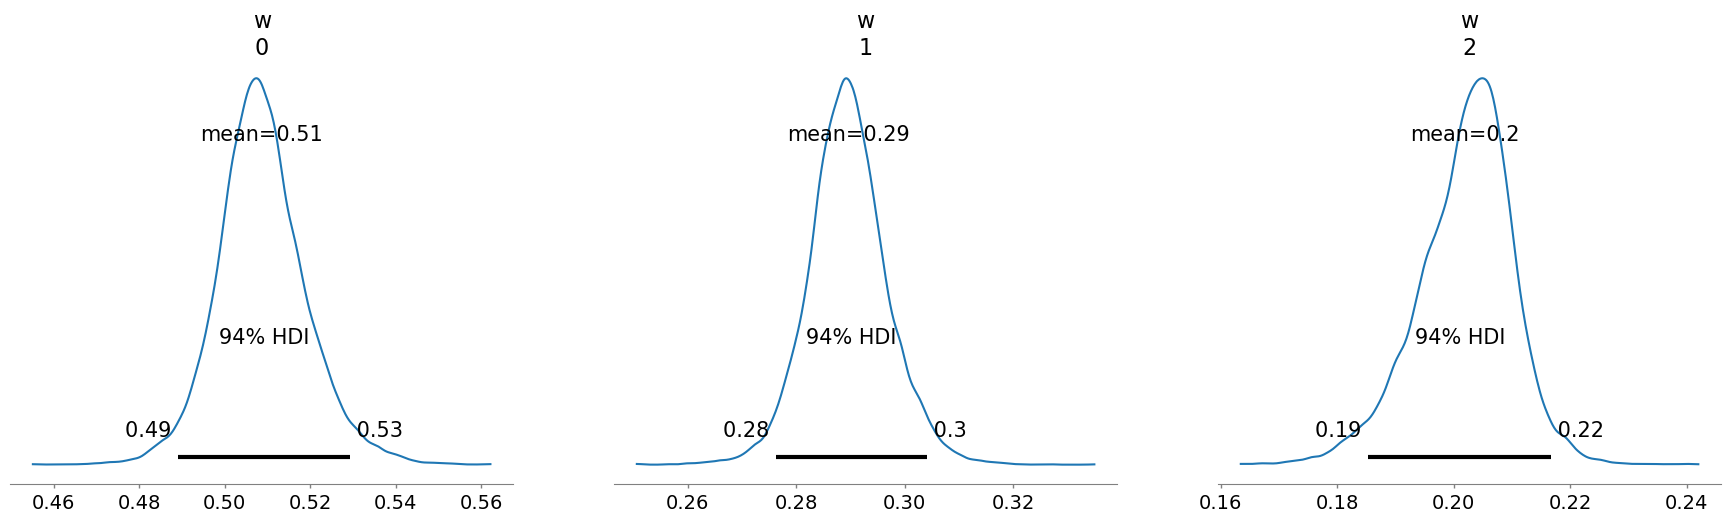

In [19]:
print('Bayesian Weights Distribution')
posterior_diagnostics(trace_case2)

## Case 3
Use Pigments 1, 2, 3, 4, 5 with weights 0.2, 0.1, 0.1, 0.3, 0.2

Ideal KM mixing

In [20]:
# Naive unmixing
naive_w_case3 = naive_unmixing(
    multispectral_experiments[2],
    absorption[to_use[2].astype(bool), :],
    scattering[to_use[2].astype(bool), :],
    wavelengths,
    measured_wavelengths
)
naive_w_mse_case3 = weight_mse(naive_w_case3, weights[2, to_use[2].astype(bool)])
print('Naive unmixing weights:', naive_w_case3)
print('Naive unmixing weights MSE:', naive_w_mse_case3)

Naive unmixing weights: [ 0.1889787   0.14112351  0.17523932  0.3795739   0.11508456]
Naive unmixing weights MSE: 0.00420324115349


In [21]:
# Greedy unmixing
greedy_w_case3, greedy_R_case3 = greedy_unmixing(
    multispectral_experiments[2],
    absorption[to_use[2].astype(bool), :],
    scattering[to_use[2].astype(bool), :],
    wavelengths,
    measured_wavelengths
)
greedy_w_mse_case3 = weight_mse(greedy_w_case3, weights[2, to_use[2].astype(bool)])
print('Greedy unmixing weights:', greedy_w_case3)
print('Greedy unmixing weights MSE:', greedy_w_mse_case3)

Greedy unmixing weights: [ 0.25  0.1   0.15  0.3   0.2 ]
Greedy unmixing weights MSE: 0.001


In [22]:
# Bayesian unimixing
trace_case3, bayesian_model_case3 = bayesian_unmixing(
    multispectral_experiments[2], 
    absorption[to_use[2].astype(bool), :],
    scattering[to_use[2].astype(bool), :],
    wavelengths, 
    measured_wavelengths,
    draws=5000, 
    tune=1000, 
    chains=4, 
    target_accept=0.9
)
bayesian_w_case3 =  trace_case3.posterior["w"].mean(dim=["chain", "draw"]).values.tolist()
bayesian_w_mse_case3 = weight_mse(bayesian_w_case3, weights[2, to_use[2].astype(bool)])
print('Bayesian unmixing weights:', bayesian_w_case3)
print('Bayesian unmixing weights MSE:', bayesian_w_mse_case3)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_w, nu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 30 seconds.


Bayesian unmixing weights: [0.2474536618904044, 0.10668278595208124, 0.17107608610836247, 0.2906190195637709, 0.1841684464853823]
Bayesian unmixing weights MSE: 0.0015373921104


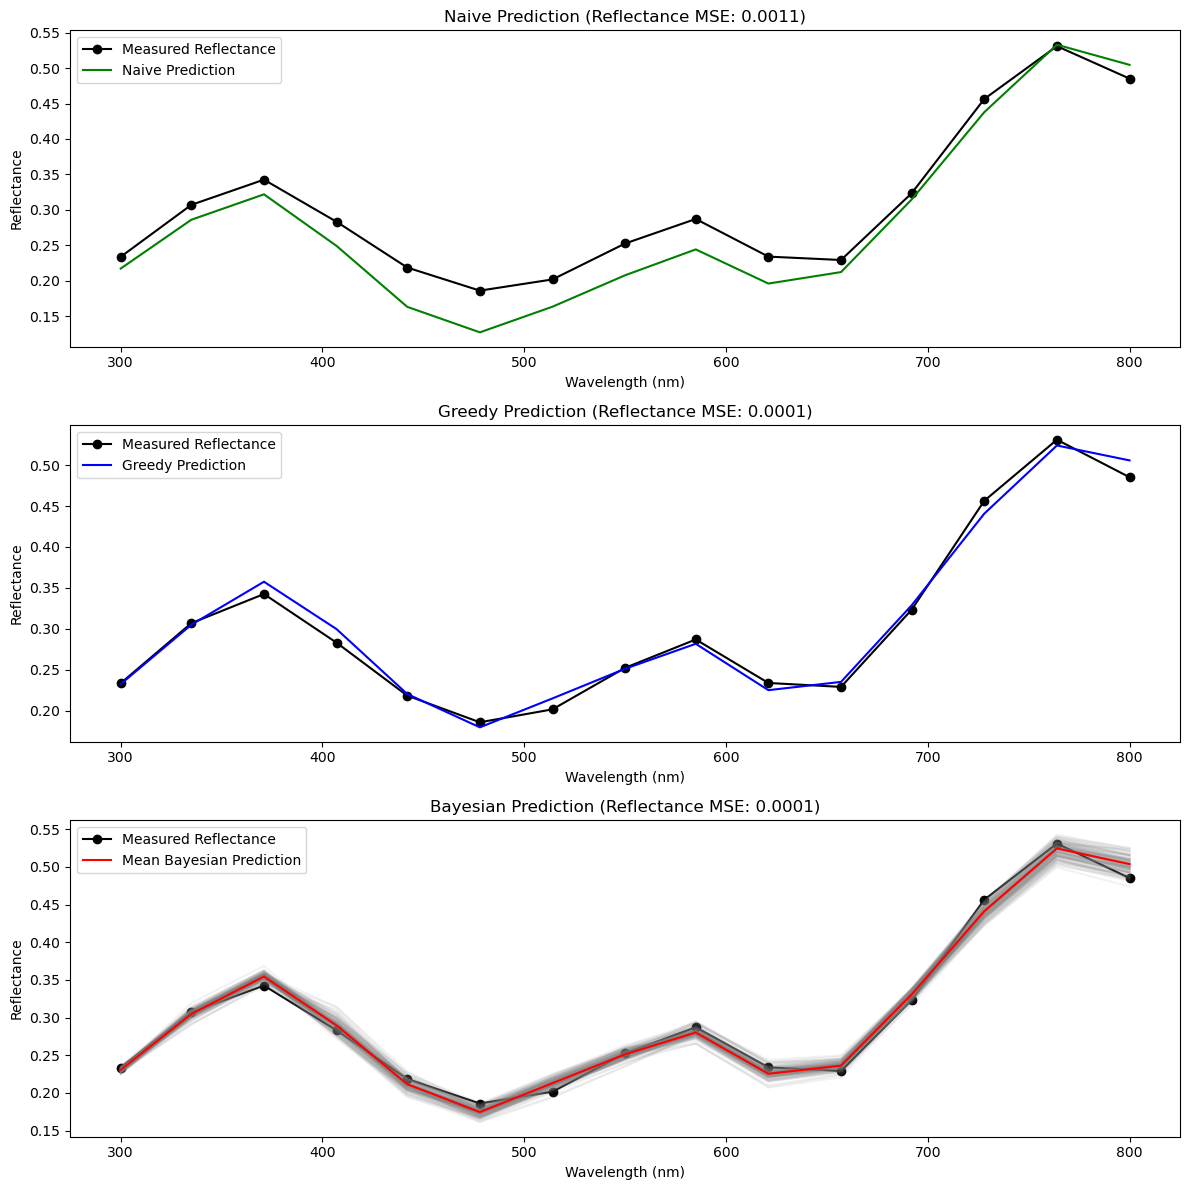

In [23]:
naive_R_mse_case3, greedy_R_mse_case3, bayesian_R_mse_case3 = compare_all_predictions(
    trace_case3, 
    greedy_w_case3, 
    naive_w_case3,
    multispectral_experiments[2], 
    absorption[to_use[2].astype(bool), :], 
    scattering[to_use[2].astype(bool), :],
    wavelengths, 
    measured_wavelengths
)

Bayesian Weights Distribution


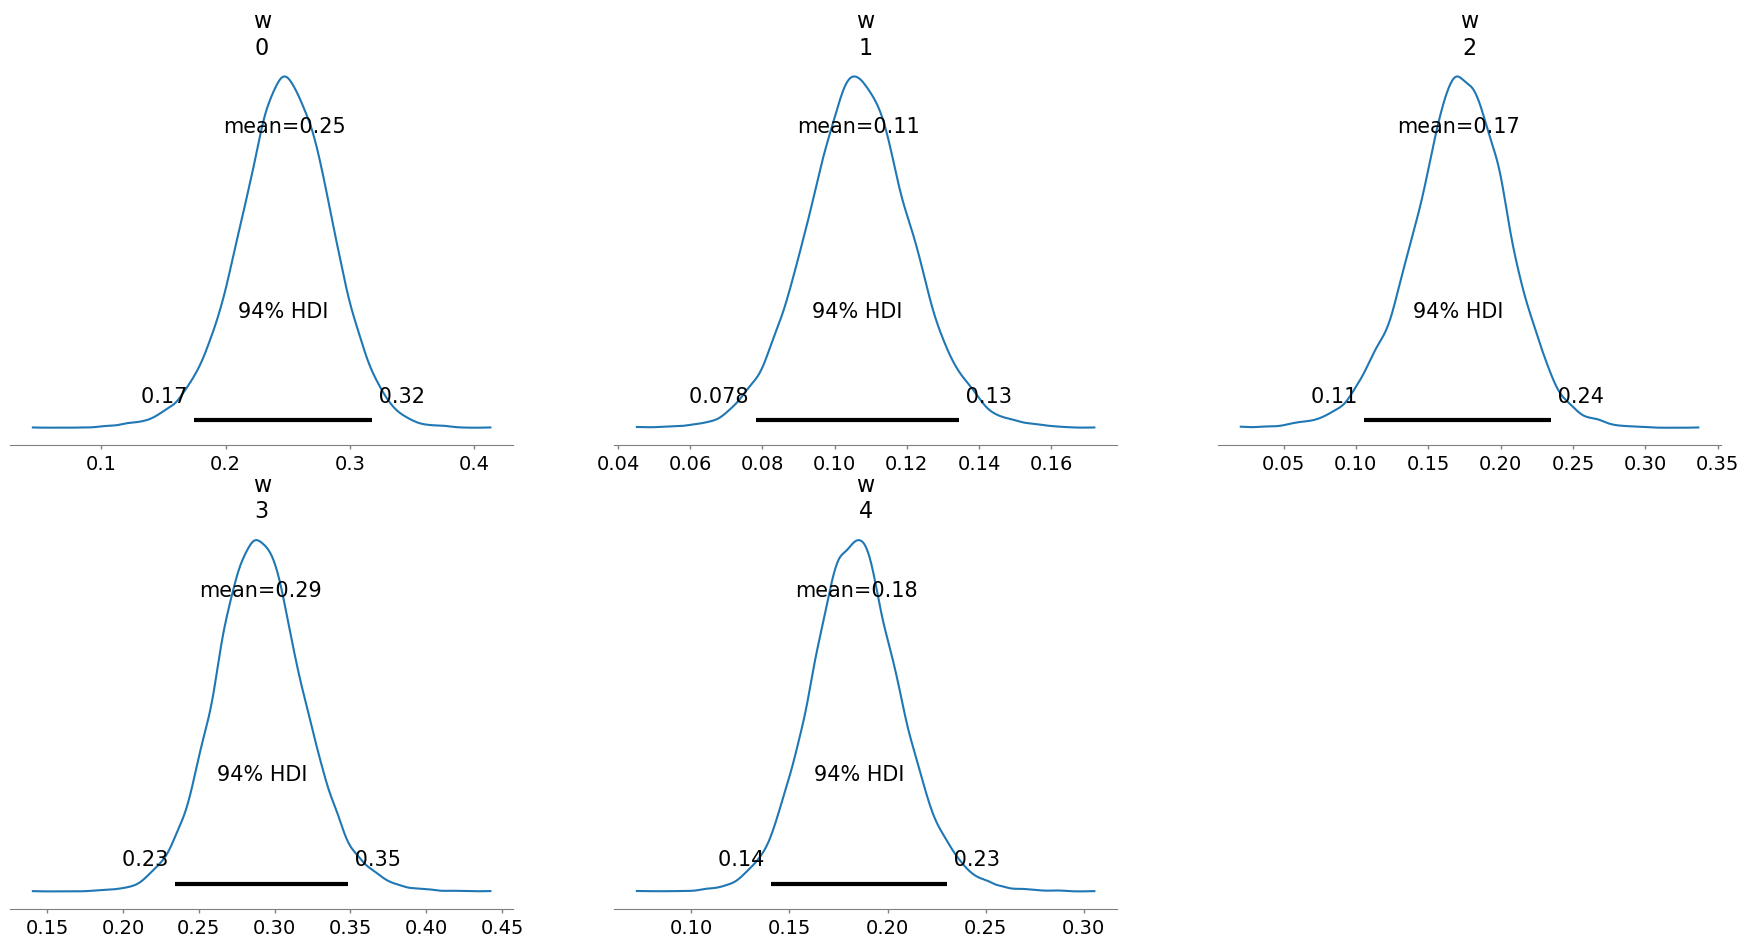

In [24]:
print('Bayesian Weights Distribution')
posterior_diagnostics(trace_case3)

### Case 4:
Use Pigments 1, 2, 3, 4 , 5 with weights 1/3, 1/3 1/3, 0, 0

Ideal KM mixing

This is to test unmixing performance when given a library of pigments where not all of them are used.

In [25]:
# Naive unmixing
naive_w_case4 = naive_unmixing(
    multispectral_experiments[3],
    absorption[to_use[3].astype(bool), :],
    scattering[to_use[3].astype(bool), :],
    wavelengths,
    measured_wavelengths
)
naive_w_mse_case4 = weight_mse(naive_w_case4, weights[3, to_use[3].astype(bool)])
print('Naive unmixing weights:', naive_w_case4)
print('Naive unmixing weights MSE:', naive_w_mse_case4)

Naive unmixing weights: [ 0.12294151  0.41294127  0.34490498  0.11206674  0.00714551]
Naive unmixing weights MSE: 0.012669212089


In [26]:
# Greedy unmixing
greedy_w_case4, greedy_R_case4 = greedy_unmixing(
    multispectral_experiments[3],
    absorption[to_use[3].astype(bool), :],
    scattering[to_use[3].astype(bool), :],
    wavelengths,
    measured_wavelengths
)
greedy_w_mse_case4 = weight_mse(greedy_w_case4, weights[3, to_use[3].astype(bool)])
print('Greedy unmixing weights:', greedy_w_case4)
print('Greedy unmixing weights MSE:', greedy_w_mse_case4)

Greedy unmixing weights: [ 0.15  0.4   0.25  0.1   0.1 ]
Greedy unmixing weights MSE: 0.013


In [27]:
# Bayesian unimixing
trace_case4, bayesian_model_case4 = bayesian_unmixing(
    multispectral_experiments[3], 
    absorption[to_use[3].astype(bool), :],
    scattering[to_use[3].astype(bool), :],
    wavelengths, 
    measured_wavelengths,
    draws=5000, 
    tune=1000, 
    chains=4, 
    target_accept=0.9
)
bayesian_w_case4 =  trace_case4.posterior["w"].mean(dim=["chain", "draw"]).values.tolist()
bayesian_w_mse_case4 = weight_mse(bayesian_w_case4, weights[3, to_use[3].astype(bool)])
print('Bayesian unmixing weights:', bayesian_w_case4)
print('Bayesian unmixing weights MSE:', bayesian_w_mse_case4)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_w, nu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 35 seconds.


Bayesian unmixing weights: [0.26368530665884343, 0.34982855196199103, 0.32029342850976417, 0.03284426166658569, 0.033348451202813836]
Bayesian unmixing weights MSE: 0.00149676873942


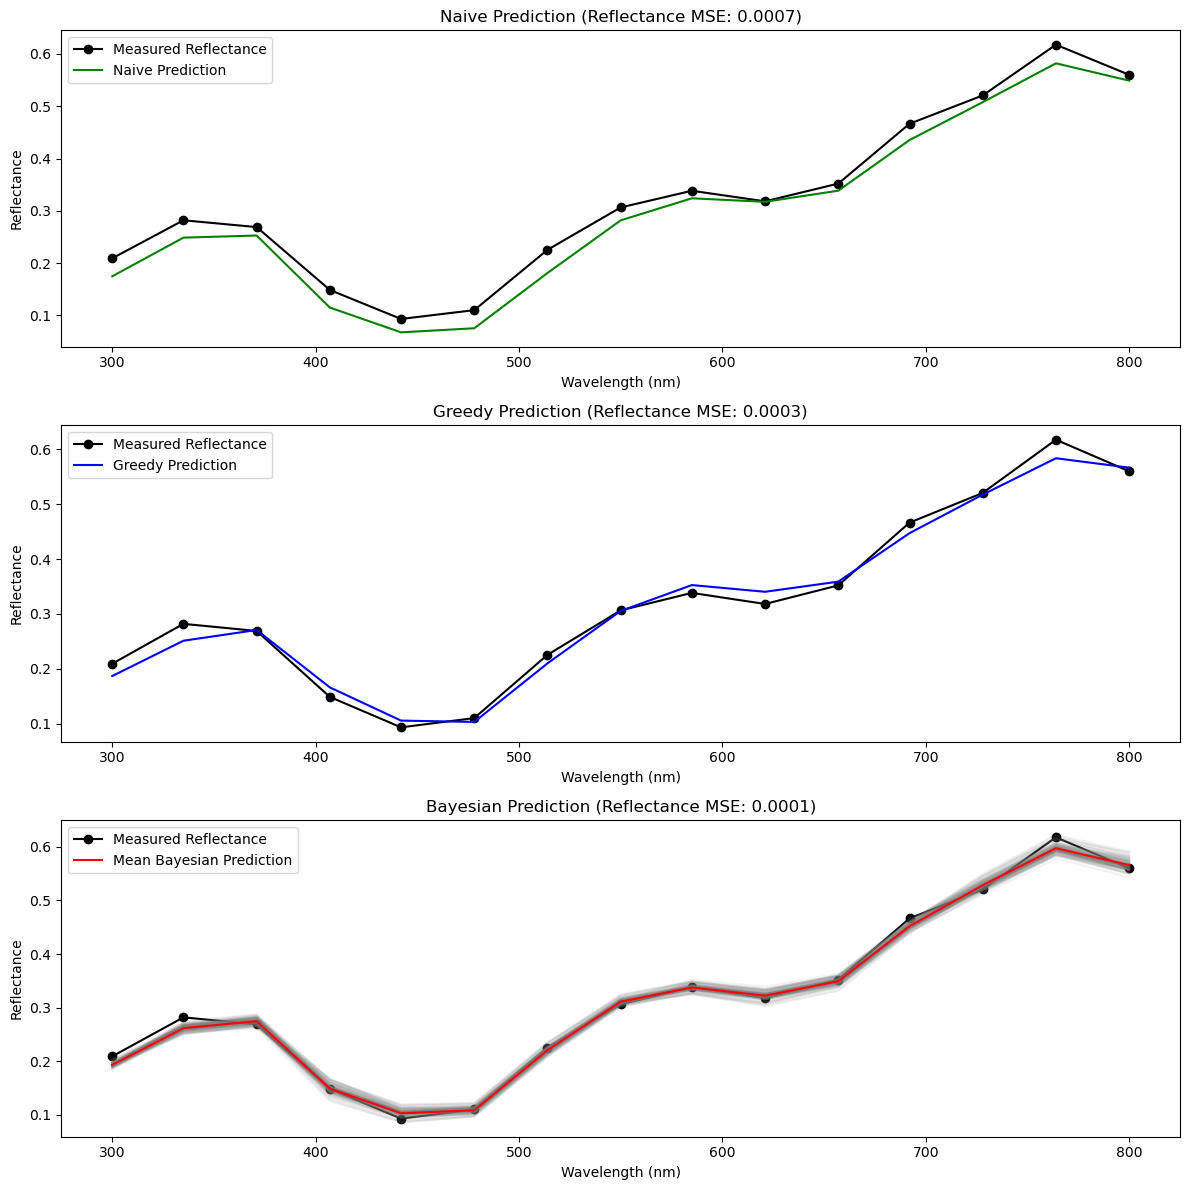

In [28]:
naive_R_mse_case4, greedy_R_mse_case4, bayesian_R_mse_case4 = compare_all_predictions(
    trace_case4, 
    greedy_w_case4, 
    naive_w_case4,
    multispectral_experiments[3], 
    absorption[to_use[3].astype(bool), :], 
    scattering[to_use[3].astype(bool), :],
    wavelengths, 
    measured_wavelengths
)

Bayesian Weights Distribution


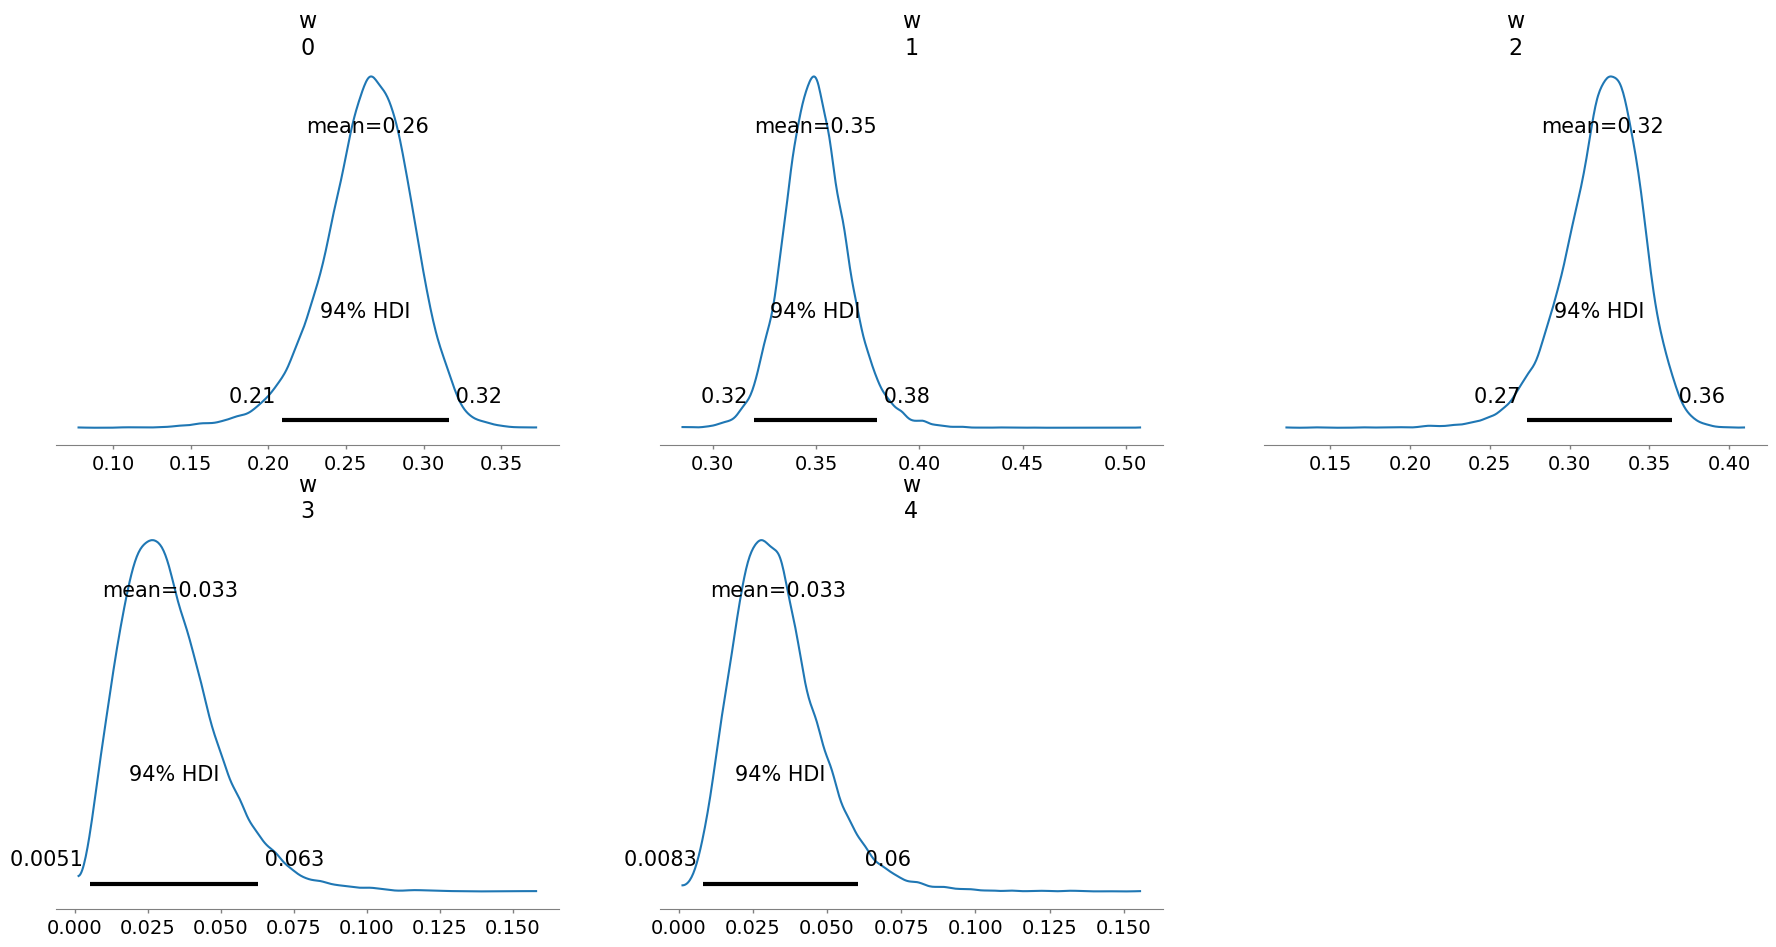

In [29]:
print('Bayesian Weights Distribution')
posterior_diagnostics(trace_case4)

### Case 5:
Use Pigments 1, 2, 3 with weights 0.3, 0.4, 0.2

Weak interaction introduced through $\alpha = 0.5$

In [30]:
# Naive unmixing
naive_w_case5 = naive_unmixing(
    multispectral_experiments[4],
    absorption[to_use[4].astype(bool), :],
    scattering[to_use[4].astype(bool), :],
    wavelengths,
    measured_wavelengths
)
naive_w_mse_case5 = weight_mse(naive_w_case5, weights[4, to_use[4].astype(bool)])
print('Naive unmixing weights:', naive_w_case5)
print('Naive unmixing weights MSE:', naive_w_mse_case5)

Naive unmixing weights: [ 0.19445298  0.53408951  0.27145751]
Naive unmixing weights MSE: 0.0114087817692


In [31]:
# Greedy unmixing
greedy_w_case5, greedy_R_case5 = greedy_unmixing(
    multispectral_experiments[4],
    absorption[to_use[4].astype(bool), :],
    scattering[to_use[4].astype(bool), :],
    wavelengths,
    measured_wavelengths
)
greedy_w_mse_case5 = weight_mse(greedy_w_case5, weights[4, to_use[4].astype(bool)])
print('Greedy unmixing weights:', greedy_w_case5)
print('Greedy unmixing weights MSE:', greedy_w_mse_case5)

Greedy unmixing weights: [ 0.23333333  0.38333333  0.38333333]
Greedy unmixing weights MSE: 0.0127777777778


In [32]:
# Bayesian unimixing
trace_case5, bayesian_model_case5 = bayesian_unmixing(
    multispectral_experiments[4], 
    absorption[to_use[4].astype(bool), :],
    scattering[to_use[4].astype(bool), :],
    wavelengths, 
    measured_wavelengths,
    draws=5000, 
    tune=1000, 
    chains=4, 
    target_accept=0.9
)
bayesian_w_case5 =  trace_case5.posterior["w"].mean(dim=["chain", "draw"]).values.tolist()
bayesian_w_mse_case5 = weight_mse(bayesian_w_case5, weights[4, to_use[4].astype(bool)])
print('Bayesian unmixing weights:', bayesian_w_case5)
print('Bayesian unmixing weights MSE:', bayesian_w_mse_case5)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_w, nu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 17 seconds.


Bayesian unmixing weights: [0.22836605628026618, 0.3955068180024741, 0.37612712571726037]
Bayesian unmixing weights MSE: 0.0120574583302


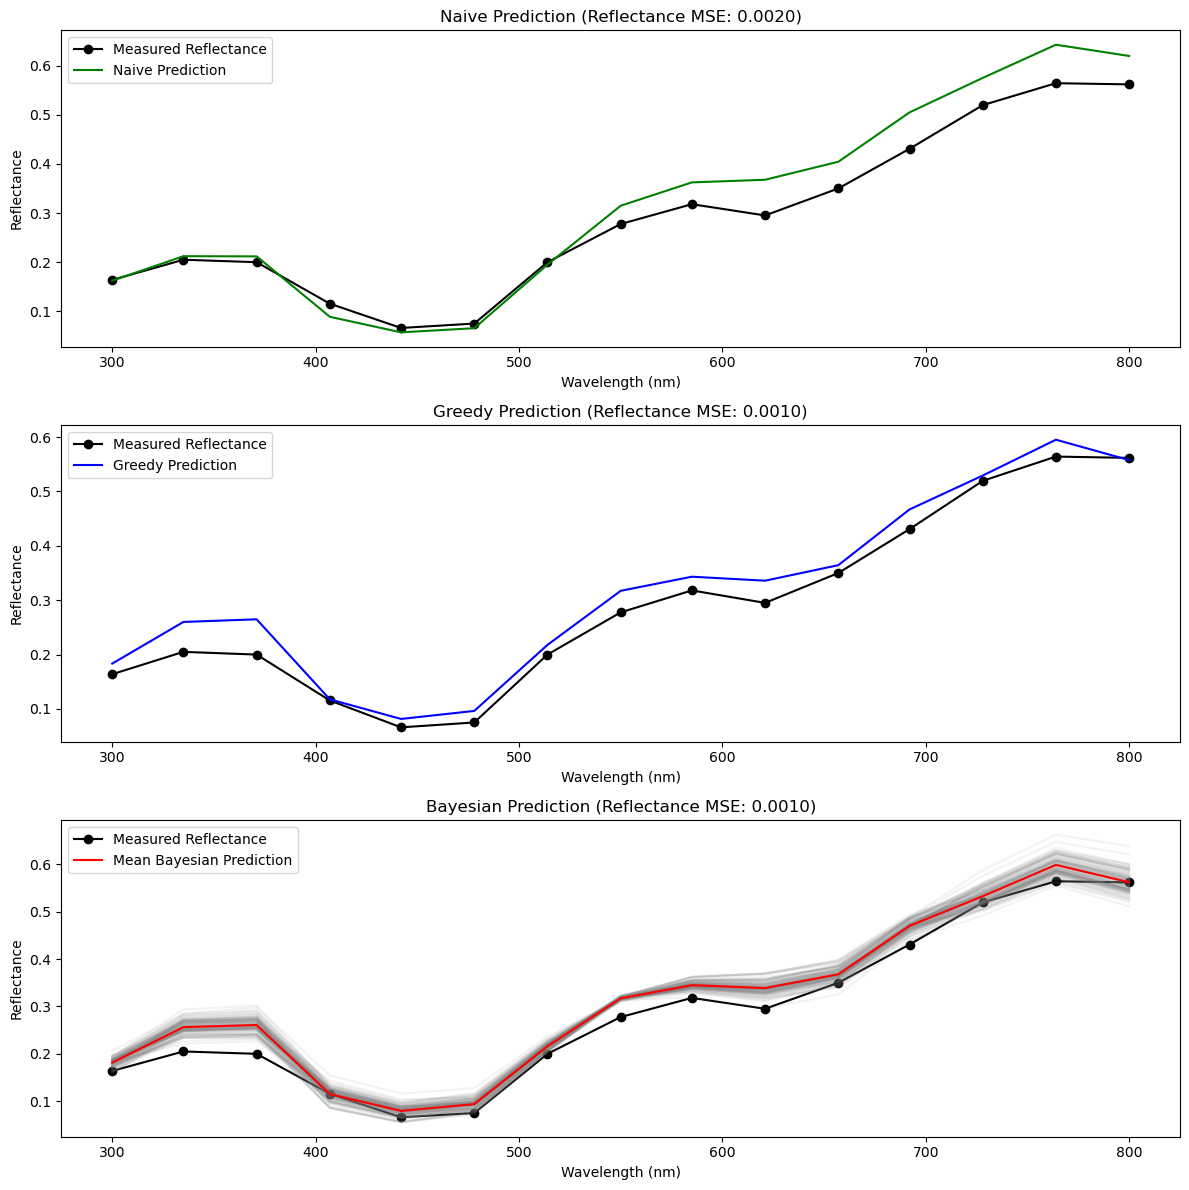

In [33]:
naive_R_mse_case5, greedy_R_mse_case5, bayesian_R_mse_case5 = compare_all_predictions(
    trace_case5, 
    greedy_w_case5, 
    naive_w_case5,
    multispectral_experiments[4], 
    absorption[to_use[4].astype(bool), :], 
    scattering[to_use[4].astype(bool), :],
    wavelengths, 
    measured_wavelengths
)

Bayesian Weights Distribution


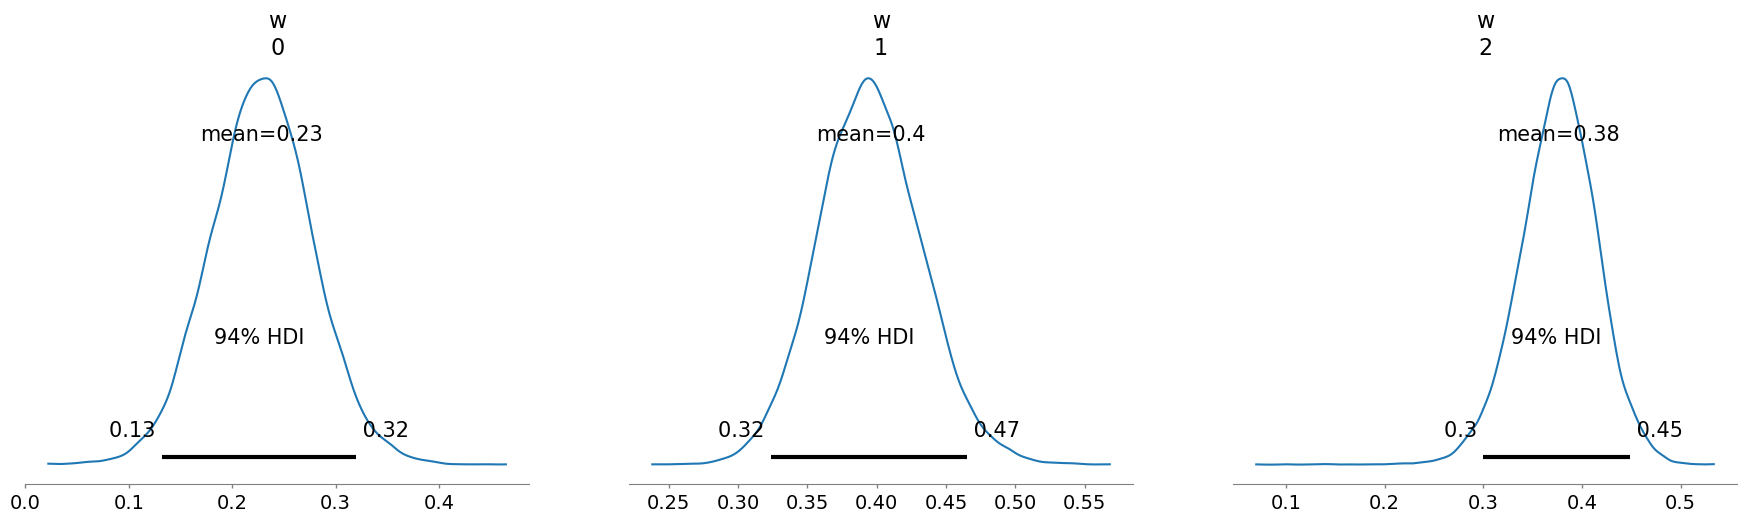

In [34]:
print('Bayesian Weights Distribution')
posterior_diagnostics(trace_case5)

### Case 6: 
Use Pigments 1, 2, 3 with weights 0.3, 0.4, 0.2

Strong interaction intruced though $\alpha = 3$

In [35]:
# Naive unmixing
naive_w_case6 = naive_unmixing(
    multispectral_experiments[5],
    absorption[to_use[5].astype(bool), :],
    scattering[to_use[5].astype(bool), :],
    wavelengths,
    measured_wavelengths
)
naive_w_mse_case6 = weight_mse(naive_w_case6, weights[5, to_use[5].astype(bool)])
print('Naive unmixing weights:', naive_w_case6)
print('Naive unmixing weights MSE:', naive_w_mse_case6)

Naive unmixing weights: [ 0.15531399  0.51571985  0.32896616]
Naive unmixing weights MSE: 0.0169857978239


In [36]:
# Greedy unmixing
greedy_w_case6, greedy_R_case6 = greedy_unmixing(
    multispectral_experiments[5],
    absorption[to_use[5].astype(bool), :],
    scattering[to_use[5].astype(bool), :],
    wavelengths,
    measured_wavelengths
)
greedy_w_mse_case6 = weight_mse(greedy_w_case6, weights[5, to_use[5].astype(bool)])
print('Greedy unmixing weights:', greedy_w_case6)
print('Greedy unmixing weights MSE:', greedy_w_mse_case6)

Greedy unmixing weights: [ 0.08333333  0.28333333  0.63333333]
Greedy unmixing weights MSE: 0.0827777777778


In [37]:
# Bayesian unimixing
trace_case6, bayesian_model_case6 = bayesian_unmixing(
    multispectral_experiments[5], 
    absorption[to_use[5].astype(bool), :],
    scattering[to_use[5].astype(bool), :],
    wavelengths, 
    measured_wavelengths,
    draws=5000, 
    tune=1000, 
    chains=4, 
    target_accept=0.9
)
bayesian_w_case6 =  trace_case6.posterior["w"].mean(dim=["chain", "draw"]).values.tolist()
bayesian_w_mse_case6 = weight_mse(bayesian_w_case6, weights[5, to_use[5].astype(bool)])
print('Bayesian unmixing weights:', bayesian_w_case6)
print('Bayesian unmixing weights MSE:', bayesian_w_mse_case6)

Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_w, nu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 21 seconds.


Bayesian unmixing weights: [0.14931888302731647, 0.12122638781899293, 0.7294547291536937]
Bayesian unmixing weights MSE: 0.126913945361


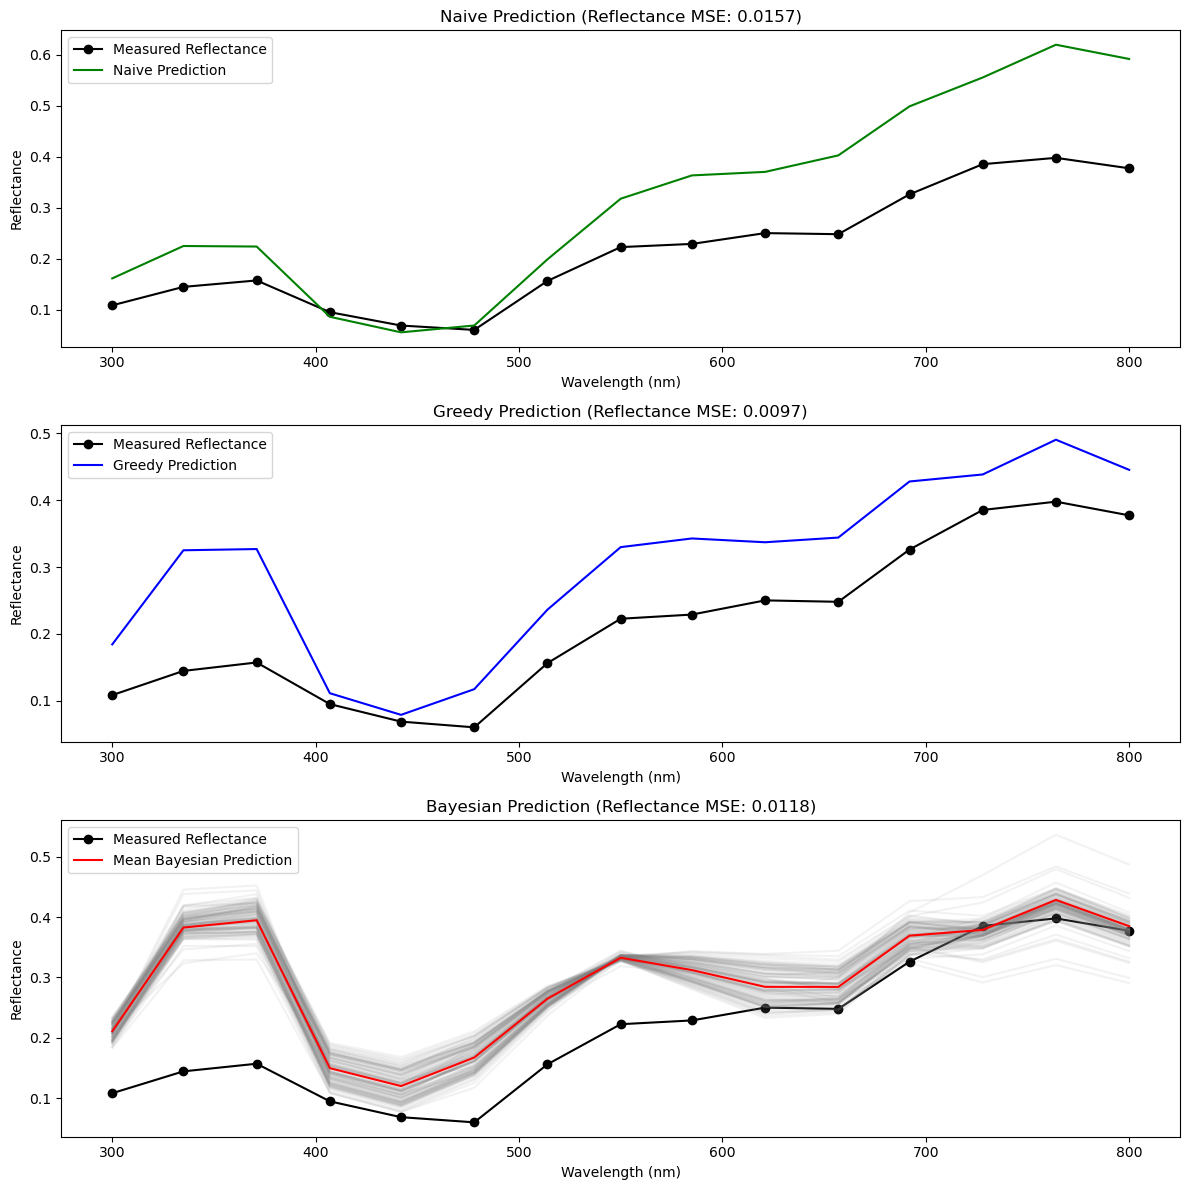

In [38]:
naive_R_mse_case6, greedy_R_mse_case6, bayesian_R_mse_case6 = compare_all_predictions(
    trace_case6, 
    greedy_w_case6, 
    naive_w_case6,
    multispectral_experiments[5], 
    absorption[to_use[5].astype(bool), :], 
    scattering[to_use[5].astype(bool), :],
    wavelengths, 
    measured_wavelengths
)

Bayesian Weights Distribution


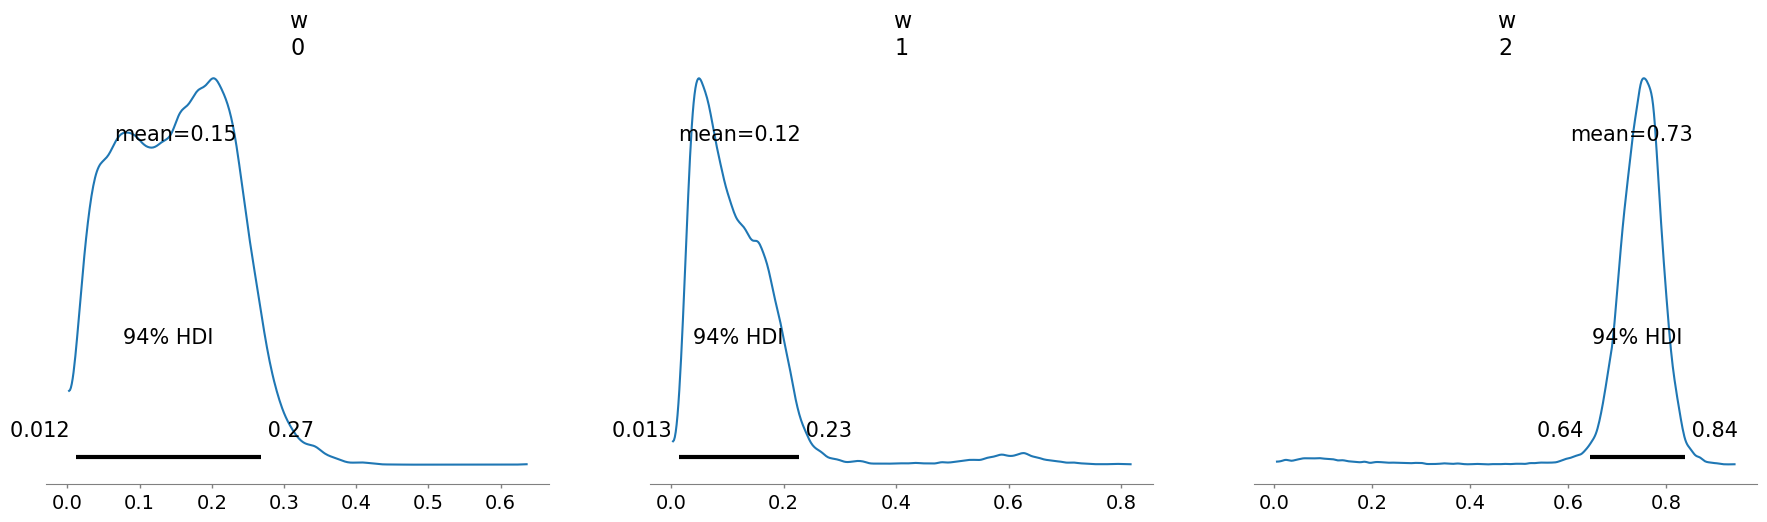

In [39]:
print('Bayesian Weights Distribution')
posterior_diagnostics(trace_case6)

# Results and Discussion

In [40]:
data = {
    'weight_mse': {
        'naive': [naive_w_mse_case1, naive_w_mse_case2, naive_w_mse_case3, naive_w_mse_case4, naive_w_mse_case5, naive_w_mse_case6],
        'greedy': [greedy_w_mse_case1, greedy_w_mse_case2, greedy_w_mse_case3, greedy_w_mse_case4, greedy_w_mse_case5, greedy_w_mse_case6],
        'bayesian': [bayesian_w_mse_case1, bayesian_w_mse_case2, bayesian_w_mse_case3, bayesian_w_mse_case4, bayesian_w_mse_case5, bayesian_w_mse_case6]
    },
    'reflectance_mse': {
        'naive': [naive_R_mse_case1, naive_R_mse_case2, naive_R_mse_case3, naive_R_mse_case4, naive_R_mse_case5, naive_R_mse_case6],
        'greedy': [greedy_R_mse_case1, greedy_R_mse_case2, greedy_R_mse_case3, greedy_R_mse_case4, greedy_R_mse_case5, greedy_R_mse_case6],
        'bayesian': [bayesian_R_mse_case1, bayesian_R_mse_case2, bayesian_R_mse_case3, bayesian_R_mse_case4, bayesian_R_mse_case5, bayesian_R_mse_case6]
    }
}
weight_styled, reflectance_styled = display_mse_comparison(data)
display(weight_styled)
display(reflectance_styled)

,naive,greedy,bayesian
1,0.006980,0.000000,0.000118
2,0.005513,0.000556,0.000062
3,0.004203,0.001000,0.001537
4,0.012669,0.013000,0.001497
5,0.011409,0.012778,0.012057
6,0.016986,0.082778,0.126914


,naive,greedy,bayesian
1,0.000470,0.000070,0.000066
2,0.000454,0.000062,0.000047
3,0.001116,0.000108,0.000090
4,0.000735,0.000300,0.000105
5,0.002046,0.001006,0.000989
6,0.015682,0.009654,0.011802


Above is a summary of the computed MSEs on both the found weights and the reconstructed refletances, where I have boxed the lowest MSE in each experiment and used a color scheme where a darker red means higher error.

It is important to note that these cases were developed as a demonstration and that generalizations of these results to actual statements of relative quality of the models used over the others is not possible without testing more sets of experiments under similar conditions. 

Below I discuss some details about the results per case.

## Cases 1, 2 and 3

These cases contained either 3 (cases 1 and 2) or 5 (case 3) pigments with non-zero weights, which were mixed without interaction (sticking to Kubelka-Munk mixing). Here we see that the naive approach underperforms the greedy and bayesian approaches in both **weight determination** and **reflectance reconstruction**.

Greedy and bayesian approaches compete for the better weight determination. It is important to note here that in case 1 (equal weights) the greedy method finds the weights without error because this method is initialized with equal weights for all pigments, so it immediatly finilized with a perfect prediction.

The bayesian method performs better that the two other approaches in **reflectance reconstruction**.

## Case 4

Case 4 contains 3 pigments with non-zero weights and 2 additional pigments with weight 0. The mixture was done without interaction terms. The purpose of doing this is to test the ability of the models to select pigments used in a mixture from a library of known pigments, when there is uncertainty regarding which subset of pigments from the library were mixed.

Here the bayesian approach outperformed the other two models considerably both in **weight determination** and in **reflectance reconstruction**. Below you can see the true weights and the weights found by each model, suggesting that bayesian models are suitable for pigment determination in a mixture from a library, when the subset of pigments used is not known.

In [41]:
print('True weights in case 4:\n', weights[3, to_use[3].astype(bool)])
print('Weights found by naive method:\n', naive_w_case4)
print('Weights found by greedy method:\n', greedy_w_case4)
print('Weights found by bayesian method:\n', bayesian_w_case4)

True weights in case 4:
 [ 0.33333333  0.33333333  0.33333333  0.          0.        ]
Weights found by naive method:
 [ 0.12294151  0.41294127  0.34490498  0.11206674  0.00714551]
Weights found by greedy method:
 [ 0.15  0.4   0.25  0.1   0.1 ]
Weights found by bayesian method:
 [0.26368530665884343, 0.34982855196199103, 0.32029342850976417, 0.03284426166658569, 0.033348451202813836]


The naive method actually assigned a very low weight to Pigment 5, showing that it was able to determinate its absence, but it was not equally successful at ruling out Pigment 4.

The greedy method did assign a smaller proportion to the absent pigments, but not in a substantial way.

The bayesian method showed good balance between assigning low weights to absent pigments and weights close to the true weights in the present pigments.

## Case 5

Case 5 contains 3 pigments with non-zero weights, mixed with weak interaction terms, thus deviating slightly from KM theory. 

In this case, the naive method performed *slightly* better that the other two at finding the true weights, but did not perform as well as the other two methods at recontructing the the reflectance curve. Given what we know about the underlying deviation from the assumed theory, this is not surprising. The greedy and bayesian approaches found weights that made the reflectance recontruction better, but by assuming true Kubelka-Munk mixing without interactions, they had to resort to **effective weights** that would fit the reflectance if the mixture was ideal.

## Case 6

Case 6 contains 3 pigments with non-zero weights, mixed with strong interaction terms, deviating considerably from KM theory.

The purpose of this case is to explore what happens when the assumptions are wrong. If I create these models thinking about idealized mixing of pigments that fits exactly with Kubelka-Munk theory, what do the results tell me if in reality there are significative non-ideal interactions that are not being accounted for by the models?

Here, the naive method performed better in terms of **weight determination** than the other models, but again, underperformed in terms of **reflectance recontruction**. Let's remember that the reconstruction of the reflectance assumes a KM mixing, and thus, finding the true weights means the recontruction is going to be off with respect to the true reflectance curve if the mixtures are not KM-ideal.

This is the only studied case where the bayesian approach did not yield the best reflectance recontruction, and the only model where it underperformed the other two models with respect to weight detemrination.

What does the bayesian model tells, though?

# A case for Bayesian modeling for dicovering model assumption insufficiency

From the results above we can see that bayesian modeling is quite good at reconstructing the reflectance and finding the underlying mixture weights when the mixture behaves the way we believe it does. What we can also see is that the bayesian approach is very **model sensitive**, and that it is a useful tool to detect wrong assumptions. 

When we fit a bayesian model to out data, we don't only get an average prediction, but we get a **probability distribution** for the variables we are intersted in. If you go back and see the plotted distributions, you can see that for the cases where the underlying simulated physics fit our assumptions, the probability distributions in the bayesian results are fairly symmetrical and unimodal. This is even the case for case 5 when we already deviated slightly from the assumed mechanism of mixing. (Intresting to note is case 4, where we introduced unused pigments in the library, resulting in slight skewness in the distributions, which may be a a sugestion for the development of a model that better handles sparsity in the weights).

Now look at case 6, where we introduced heavy deviation from our assumptions. Here the learned distributions are skewed, non-symmetric and in one of them, with a tendency to multi-modality. This to me is a suggestion of insufficinecy of the model assumptions, which is very valuable information, as it suggests, as in this case, a deviation from the physical principles assumed when studying the mixture of these pigments. This is not something that can be easily seen of derived from the other methods.

Bayesian modeling is computationally expensive as it requires significant sampling to fit the posterior distribution. In many cases, as we have seen, it may be considered overkill, and a simpler, leaner model can suffice. The power of bayesian modeling is truly seen when we encounter unknown "hidden variables", and is an invaluable tool when we want to test our assumptions.